# Lab 5 - NBA Playoffs
Kirstin Pruitt, Mahsa Sheikhihafshejani, Larry Yu

## Preparation (4 points total)
+  [**1 points**] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 
+  [**1 points**] Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed). 
+  [**1 points**] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a **detailed argument for why this (these) metric(s) are appropriate** on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
+  [**1 points**] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). **Explain why your chosen method is appropriate or use more than one method as appropriate.** Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

This data was scraped from [basketball-reference.com](https://www.basketball-reference.com/). It includes basic and advanced level game statistics for all teams competing in the 2011 - 2022 NBA seasons (28,396 games total). Most of the feature engineering was done in R (and will be attached as a secondary html for reference). The `rest_days` variable was included as the date of the present game minus the previous game. If the observation is a team's first game of the season, the number of rest days was assigned as 120, since that is the approximate break between seasons. The `points_diff` variable was created to gauge how much a team tends to win or lose by, but is only important for creating the `points_diff_5` and then it is dropped (since it is a linear combination of `team_score` - `opp_score`). The `ppg_5` and `points_diff_5` variables were created as moving averages across the last 5 games for the purpose of prospective modeling. Furthermore, a binary classifier, `avg_comp`, was created to indicate whether a team's average points scored in the last 5 games (`ppg_5`) is above or below the league average at the respective time. Another categorical variable was created based on the value of momentum (`rho_sign`) to indicate whether a teams momentum at a given point is negative, zero, or positive. These variables were created to serve as the wide portion of the network. Lastly, the variables indicating shots made by either team in a game were dropped since the volume of shots taken is captured by the variables whose names end in `a` (for attempted) and the scoring efficiency of respective shots is captured by the variables whose names end in `percent`. 

There are not very many categorical features in this dataset, but one set that we will combine into a cross-product feature will indicate whether a game was home or away and won or lost. This will result in 4 possible combinations that are meaningful in the context of an NBA game. It is often thought that the Home Team has an advantage in sports, so a home-win could be more likely than an away-win, and vice versa with patterns of losing. Crossing these features will allow our model to account for these circumstances and determine whether they are important for determining whether a team will make the playoffs. Other crossings are broken down in more detail where they occur in the notebook. We ultimately expect to have 59 features being utilized in the network. 

The prediction task at hand is to accurately determine whether a team will make playoffs at any given point in the season. While we acknowledge that accuracy is typically not the most appropriate metric for evaluating model performance, we believe it will be the most telling in this circumstance. Since we care equally about whether a team makes the playoffs or not, we want our model to correctly predict teams who *do* and *do not* make the playoffs, and we do not value one class's prediction over another. We will also evaluate ROC-AUC in hopes that our model will maximize the area under the curve in the binary playoff prediction task. 

Given the nature of the propspective modeling, we decided to do a temporal train/test split. The training data consists of all games in the 2011 - 2019 seasons (21,658 total), while the testing data consists of all games from the 2020 - 2022 seasons (6,738 total) which is close to a 76:24 split. We will use 10-fold cross-validation (with no repeats) to train the model since the training set is of moderate size, but 10-fold cross validation ensures we are getting and utilizing adequate information from the training set. We do not need to account for any notable imbalance since 16/30 NBA teams make the playoffs per season. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
games = pd.read_csv(r'/Users/kirstinpruitt/Desktop/nba_games2.csv')
games.head()

,g,date,opp,team_score,opp_score,fg,fga,fg_percent,x3p,x3pa,...,season,momentum,playoffs,home,win,rest_days,points_diff,ppg_5,diff_pg_5,avg_comp
0,1,10/27/10,NOH,91,95,33,77,0.429,8,23,...,2011,-1,0,0,0,120,-4,91.000000,-4.000000,BELOW
1,2,10/29/10,MIN,85,96,31,87,0.356,3,20,...,2011,-2,0,0,0,2,-11,88.000000,-7.500000,BELOW
2,3,10/30/10,CHA,98,88,32,71,0.451,11,22,...,2011,-1,0,1,1,1,10,91.333333,-1.666667,BELOW
3,4,11/2/10,POR,76,90,27,72,0.375,3,15,...,2011,-2,0,1,0,3,-14,87.500000,-4.750000,BELOW
4,5,11/3/10,BOS,102,105,36,86,0.419,5,13,...,2011,-3,0,0,0,1,-3,90.400000,-4.400000,BELOW


In [3]:
games = games.drop(['date', 'fg', 'x3p', 'ft', 'fg_opp', 'x3p_opp', 'ft_opp', 'points_diff'], axis = 1)
# will also drop season, but need to keep it for now to do the temporal train/test split

In [4]:
games.shape

(28396, 58)

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler # 0 mean, 1 unit SD

encoders = dict() # save each encoder in dictionary
categorical_headers = ['team','opp', 'avg_comp'] # win, home, and playoffs are already binaries

# train all encoders (special case the target 'income')
for col in categorical_headers:
    games[col] = games[col].str.strip()
    # integer encode strings that are features
    encoders[col] = LabelEncoder() # save the encoder
    games[col+'_int'] = encoders[col].fit_transform(games[col])

In [196]:
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [197]:
team_tab = games.groupby(['team', 'team_int']).size().reset_index().rename(columns={0:'count'})
opp_tab = games.groupby(['opp', 'opp_int']).size().reset_index().rename(columns={0:'count'})
display(team_tab)
display(opp_tab)

,team,team_int,count
0,ATL,0,943
1,BOS,1,947
2,BRK,2,800
3,CHA,3,312
4,CHI,4,941
5,CHO,5,629
6,CLE,6,941
7,DAL,7,951
8,DEN,8,949
9,DET,9,942


,opp,opp_int,count
0,ATL,0,943
1,BOS,1,947
2,BRK,2,800
3,CHA,3,312
4,CHI,4,941
5,CHO,5,629
6,CLE,6,941
7,DAL,7,951
8,DEN,8,949
9,DET,9,942


In [8]:
cols = games.columns.tolist()
rem_cols = {"opp", "team", "opp_int", "team_int", "season", "playoffs", "home", "win", "avg_comp", "avg_comp_int"}
numeric_headers = [x for x in cols if x not in rem_cols]

In [9]:
games.loc[(games['home'] == 1), 'LOCATION'] = "HOME"
games.loc[(games['home'] == 0), 'LOCATION'] = "AWAY"
games.loc[(games['win'] == 1), 'OUTCOME'] = "WIN"
games.loc[(games['win'] == 0), 'OUTCOME'] = "LOSE"
games.loc[(games['momentum'] > 0), 'rho_sign'] = "POSITIVE"
games.loc[(games['momentum'] == 0), 'rho_sign'] = "ZERO"
games.loc[(games['momentum'] < 0), 'rho_sign'] = "NEGATIVE"

In [10]:
ss = StandardScaler()
games[numeric_headers] = ss.fit_transform(games[numeric_headers].to_numpy()) # should be to_numpy()

In [11]:
categorical_headers = ["opp_int", "team_int", "avg_comp_int", "home", "win", "season"]
feature_columns = categorical_headers + numeric_headers

*Note*: `avg_comp_int` is somewhat backwards in thought. Above the league average is 0, and below the league average is 1. Renaming it for clarification below.

In [12]:
categorical_headers.remove("season")

In [13]:
categorical_headers = list(map(lambda x: x.replace('avg_comp_int', 'below_avg_int'), categorical_headers))

In [14]:
print(categorical_headers)
print(numeric_headers) 

['opp_int', 'team_int', 'below_avg_int', 'home', 'win']
['g', 'team_score', 'opp_score', 'fga', 'fg_percent', 'x3pa', 'x3p_percent', 'fta', 'ft_percent', 'orb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'fga_opp', 'fg_percent_opp', 'x3pa_opp', 'x3p_percent_opp', 'fta_opp', 'ft_percent_opp', 'orb_opp', 'trb_opp', 'ast_opp', 'stl_opp', 'blk_opp', 'tov_opp', 'pf_opp', 'o_rtg', 'd_rtg', 'pace', 'f_tr', 'x3p_ar', 'ts_percent', 'trb_percent', 'ast_percent', 'stl_percent', 'blk_percent', 'e_fg_percent_off', 'tov_percent_off', 'orb_percent', 'ft_fga_off', 'e_fg_percent_def', 'tov_percent_def', 'drb_percent', 'ft_fga_def', 'momentum', 'rest_days', 'ppg_5', 'diff_pg_5']


* **Crossing Option 1**: `team` and `opp`
  +  1044 combinations 
  +  probably not a fruitful exercise, but a motivating scenario is to consider the Sacramento Kings (who haven't made the playoffs since the 2006-07 season [1], so not at all in the dataset) and the San Antonio Spurs (who almost always make the playoffs (in the training set)) 

* **Crossing Option 2**: `home` and `win`, we can apply this to the network to get four unique options:
  +  home_win (1_1)
  +  home_lose (1_0)
  +  away_win (0_1)
  +  away_lose (0_0)
  
* **Crossing Option 3**: `home` + `win` + `avg_comp`
  +  8 combinations
  +  motivating example: if a team that wins a lot of home and away games also averages more ppg than the league avg, it is plausible for the network to learn this as a scenario that should predict that team making playoffs
  
* **Crossing Option 4**: `home` + `win` + `rho_sign`
  +  12 combinations 
  +  similar to before, but motivating example: if a team that wins a lot of home and away games also has a positive raw momentum score, it is plausible for the network to learn this as a scenario that should predict that team making playoffs. if the team has a zero momentum score, maybe the network becomes less confident in the outcome. 
  
* **Crossing Option 5**: `avg_comp` + `rho_sign` 
  +  6 combinations
  +  motivating example: if a team averages more ppg than the league avg and has a positive raw momentum score, it is plausible for the network to learn this as a scenario that should predict that team making playoffs. 

The crossed columns used for this lab were:
  1.  Crossing Option 2 $\times$ Crossing Option 5
  2.  Crossing Option 1 $\times$ Crossing Option 3
  3.  Crossing Option 1 $\times$ Crossing Option 4
 

*Note*: If we were not concerned about prospective modeling, we could do Shuffle Splits and then memorize matchups per season, which would probably be better than just memorizing matchups as above.

In [15]:
# a quick example of crossing some columns

cols_list = ['team','opp']

# 1. create crossed labels by string join operation
X_crossed_train = games[cols_list].apply(lambda x: '_'.join(x), axis=1)
X_crossed_test = games[cols_list].apply(lambda x: '_'.join(x), axis=1)

# combine together for training
all_vals = np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy()))
print(np.unique(all_vals))
    
# 2. encode as integers, stacking all possibilities
enc = LabelEncoder()
enc.fit(all_vals)

encoded_vals_train = enc.transform(X_crossed_train)
encoded_vals_test  = enc.transform(X_crossed_test)

print(np.min(encoded_vals_train), np.max(encoded_vals_train))

['ATL_BOS' 'ATL_BRK' 'ATL_CHA' ... 'WAS_SAS' 'WAS_TOR' 'WAS_UTA']
0 1043


In [16]:
# a quick example of crossing some columns

cols_list = ['LOCATION','OUTCOME']

# 1. create crossed labels by string join operation
X_crossed_train = games[cols_list].apply(lambda x: '_'.join(x), axis=1)
X_crossed_test = games[cols_list].apply(lambda x: '_'.join(x), axis=1)

# combine together for training
all_vals = np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy()))
print(np.unique(all_vals))
    
# 2. encode as integers, stacking all possibilities
enc = LabelEncoder()
enc.fit(all_vals)

encoded_vals_train = enc.transform(X_crossed_train)
encoded_vals_test  = enc.transform(X_crossed_test)

print(np.min(encoded_vals_train), np.max(encoded_vals_train))

['AWAY_LOSE' 'AWAY_WIN' 'HOME_LOSE' 'HOME_WIN']
0 3


In [17]:
# a quick example of crossing some columns

cols_list = ['LOCATION','OUTCOME', 'avg_comp']

# 1. create crossed labels by string join operation
X_crossed_train = games[cols_list].apply(lambda x: '_'.join(x), axis=1)
X_crossed_test = games[cols_list].apply(lambda x: '_'.join(x), axis=1)

# combine together for training
all_vals = np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy()))
print(np.unique(all_vals))
    
# 2. encode as integers, stacking all possibilities
enc = LabelEncoder()
enc.fit(all_vals)

encoded_vals_train = enc.transform(X_crossed_train)
encoded_vals_test  = enc.transform(X_crossed_test)

print(np.min(encoded_vals_train), np.max(encoded_vals_train))

['AWAY_LOSE_ABOVE' 'AWAY_LOSE_BELOW' 'AWAY_WIN_ABOVE' 'AWAY_WIN_BELOW'
 'HOME_LOSE_ABOVE' 'HOME_LOSE_BELOW' 'HOME_WIN_ABOVE' 'HOME_WIN_BELOW']
0 7


In [18]:
# a quick example of crossing some columns

cols_list = ['LOCATION','OUTCOME', 'rho_sign']

# 1. create crossed labels by string join operation
X_crossed_train = games[cols_list].apply(lambda x: '_'.join(x), axis=1)
X_crossed_test = games[cols_list].apply(lambda x: '_'.join(x), axis=1)

# combine together for training
all_vals = np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy()))
print(np.unique(all_vals))
    
# 2. encode as integers, stacking all possibilities
enc = LabelEncoder()
enc.fit(all_vals)

encoded_vals_train = enc.transform(X_crossed_train)
encoded_vals_test  = enc.transform(X_crossed_test)

print(np.min(encoded_vals_train), np.max(encoded_vals_train))

['AWAY_LOSE_NEGATIVE' 'AWAY_LOSE_POSITIVE' 'AWAY_LOSE_ZERO'
 'AWAY_WIN_NEGATIVE' 'AWAY_WIN_POSITIVE' 'AWAY_WIN_ZERO'
 'HOME_LOSE_NEGATIVE' 'HOME_LOSE_POSITIVE' 'HOME_LOSE_ZERO'
 'HOME_WIN_NEGATIVE' 'HOME_WIN_POSITIVE' 'HOME_WIN_ZERO']
0 11


In [19]:
# a quick example of crossing some columns

cols_list = ['avg_comp', 'rho_sign']

# 1. create crossed labels by string join operation
X_crossed_train = games[cols_list].apply(lambda x: '_'.join(x), axis=1)
X_crossed_test = games[cols_list].apply(lambda x: '_'.join(x), axis=1)

# combine together for training
all_vals = np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy()))
print(np.unique(all_vals))
    
# 2. encode as integers, stacking all possibilities
enc = LabelEncoder()
enc.fit(all_vals)

encoded_vals_train = enc.transform(X_crossed_train)
encoded_vals_test  = enc.transform(X_crossed_test)

print(np.min(encoded_vals_train), np.max(encoded_vals_train))

['ABOVE_NEGATIVE' 'ABOVE_POSITIVE' 'ABOVE_ZERO' 'BELOW_NEGATIVE'
 'BELOW_POSITIVE' 'BELOW_ZERO']
0 5


In [20]:
data = games
data.head()

,g,opp,team_score,opp_score,fga,fg_percent,x3pa,x3p_percent,fta,ft_percent,...,rest_days,ppg_5,diff_pg_5,avg_comp,team_int,opp_int,avg_comp_int,LOCATION,OUTCOME,rho_sign
0,-1.695162,NOH,-1.025281,-0.723340,-1.066814,-0.519717,-0.370562,-0.069648,0.705461,-1.515230,...,8.435188,-1.553850,-0.519635,BELOW,17,20,1,AWAY,LOSE,NEGATIVE
1,-1.651851,MIN,-1.478192,-0.647855,0.244434,-1.840023,-0.705914,-2.057502,0.298447,0.347121,...,-0.122318,-1.898398,-0.973373,BELOW,17,18,1,AWAY,LOSE,NEGATIVE
2,-1.608540,CHA,-0.496885,-1.251736,-1.853562,-0.121817,-0.482346,1.456381,0.569789,0.848894,...,-0.194839,-1.515566,-0.217143,BELOW,17,3,1,HOME,WIN,NEGATIVE
3,-1.565229,POR,-2.157558,-1.100766,-1.722438,-1.496382,-1.264835,-1.555519,0.298447,-0.038859,...,-0.049796,-1.955823,-0.616865,BELOW,17,27,1,HOME,LOSE,NEGATIVE
4,-1.521918,BOS,-0.194944,0.031512,0.113310,-0.700581,-1.488403,0.301820,1.112474,0.405018,...,-0.194839,-1.622759,-0.571491,BELOW,17,1,1,AWAY,LOSE,NEGATIVE


In [21]:
data = data.rename(columns={'avg_comp_int': 'below_avg_int'})

In [22]:
# temporally split the data into training and testing for predictions to be useful
train = data[data['season'] <= 2019]
test = data[data['season'] > 2019]

X_train = train.drop('season', axis = 1)
X_test = test.drop('season', axis = 1)

#X_train = train#.to_numpy()
#X_test = test#.to_numpy()

print(X_train.shape, X_test.shape)

(21658, 63) (6738, 63)


In [23]:
train_indexes = []
test_indexes = []

for index, season in enumerate(games.season):
    if season <= 2019:
        train_indexes.append(index)
    else:
        test_indexes.append(index)      
        
y_train = games.loc[train_indexes, ['playoffs']].values.astype(np.int32)
y_test = games.loc[test_indexes, ['playoffs']].values.astype(np.int32)

## Modeling (5 points total)
+  [**2 points**] Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.
+  [**2 points**] Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly. 
+ [**1 points**] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). For classification tasks, compare using the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical methods to compare the performance of different models.  

In [24]:
from sklearn import metrics as mt
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

2.10.1
2.10.0


In [25]:
from tensorflow.keras.layers import Dense, Activation, Input, Embedding, concatenate
from tensorflow.keras.models import Model

### Creating Crossed Categories for Wide Network

In [26]:
# now let's create some different crossed values
# possible crossing options:
#   'LOCATION','OUTCOME';
#   'team','opp';
#   'LOCATION','OUTCOME','avg_comp'
#   'LOCATION','OUTCOME','rho_sign'

# choose these as a class, what makes sense??
cross_columns = [['LOCATION','OUTCOME'],
                 ['avg_comp','rho_sign'],
                 #['LOCATION','OUTCOME','avg_comp'],
                 #['LOCATION','OUTCOME','rho_sign']
                ]

# cross each set of columns in the list above
cross_col_df_names1 = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = games[games['season'] <= 2019][cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = games[games['season'] > 2019][cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    X_train[cross_col_name] = enc.transform(X_crossed_train)
    X_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names1.append(cross_col_name) 
cross_col_df_names1

['LOCATION_OUTCOME', 'avg_comp_rho_sign']

In [27]:
# now let's create some different crossed values
# possible crossing options:
#   'LOCATION','OUTCOME';
#   'team','opp';
#   'LOCATION','OUTCOME','avg_comp'
#   'LOCATION','OUTCOME','rho_sign'

# choose these as a class, what makes sense??
cross_columns = [#['LOCATION','OUTCOME'],
                 ['team','opp'],
                 ['LOCATION','OUTCOME','avg_comp'],
                 #['LOCATION','OUTCOME','rho_sign']
                ]

# cross each set of columns in the list above
cross_col_df_names2 = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = games[games['season'] <= 2019][cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = games[games['season'] > 2019][cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    X_train[cross_col_name] = enc.transform(X_crossed_train)
    X_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names2.append(cross_col_name) 
cross_col_df_names2

['team_opp', 'LOCATION_OUTCOME_avg_comp']

In [28]:
# now let's create some different crossed values
# possible crossing options:
#   'LOCATION','OUTCOME';
#   'team','opp';
#   'LOCATION','OUTCOME','avg_comp'
#   'LOCATION','OUTCOME','rho_sign'

# choose these as a class, what makes sense??
cross_columns = [#['LOCATION','OUTCOME'],
                 ['team','opp'],
                 #['LOCATION','OUTCOME','avg_comp'],
                 ['LOCATION','OUTCOME','rho_sign']
                ]

# cross each set of columns in the list above
cross_col_df_names3 = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = games[games['season'] <= 2019][cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = games[games['season'] > 2019][cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    X_train[cross_col_name] = enc.transform(X_crossed_train)
    X_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names3.append(cross_col_name) 
cross_col_df_names3

['team_opp', 'LOCATION_OUTCOME_rho_sign']

### Wide and Deep Network 1

In [88]:
from sklearn.model_selection import KFold
from sklearn import metrics as mt

In [30]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [31]:
kfold = 1
kf = KFold(n_splits = 10, shuffle = True, random_state = 24)

VALIDATION_ACCURACY1 = []
VALIDATION_AUC1 = []

for train_index, val_index in kf.split(X_train):
    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]
    y_train1 = y_train[[train_index]].reshape(-1,1)
    y_val = y_train[[val_index]].reshape(-1,1)
    
    # get crossed columns
    X_train_crossed = training_data[cross_col_df_names1].to_numpy()
    X_test_crossed = validation_data[cross_col_df_names1].to_numpy()

    # save categorical features
    X_train_cat = training_data[categorical_headers].to_numpy() 
    X_test_cat = validation_data[categorical_headers].to_numpy() 

    # and save off the numeric features
    X_train_num =  training_data[numeric_headers].to_numpy()
    X_test_num = validation_data[numeric_headers].to_numpy()
    
    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names1):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        crossed_outputs.append(x)
    

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch], name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)
    
    model1 = Model(inputs=[input_crossed,input_cat,input_num], outputs=final_branch)
    
    model1.compile(loss = "mean_squared_error",
                 optimizer = 'sgd', metrics = ['accuracy', 'AUC'])
    
    save_dir = '\saved_models1/'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(kfold), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    history1 = model1.fit([X_train_crossed,X_train_cat,X_train_num], y_train1, epochs=15, batch_size=32, verbose=1,
                        callbacks = [callbacks_list],
                        validation_data = ([X_test_crossed,X_test_cat,X_test_num], y_val))
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model1.load_weights("\saved_models1/model_"+str(kfold)+".h5")

    results = model1.evaluate([X_test_crossed,X_test_cat,X_test_num], y_val)
    results = dict(zip(model1.metrics_names,results))

    VALIDATION_ACCURACY1.append(results['accuracy'])
    VALIDATION_AUC1.append(results['auc'])
    
    tf.keras.backend.clear_session()
    
    kfold += 1

Epoch 1/15
573/610 [===========================>..] - ETA: 0s - loss: 0.2378 - accuracy: 0.6211 - auc: 0.7035
Epoch 1: val_accuracy improved from -inf to 0.77424, saving model to \saved_models1/model_1.h5
610/610 [==============================] - 2s 2ms/step - loss: 0.2368 - accuracy: 0.6284 - auc: 0.7134 - val_loss: 0.2195 - val_accuracy: 0.7742 - val_auc: 0.8502
Epoch 2/15
562/610 [==========================>...] - ETA: 0s - loss: 0.2042 - accuracy: 0.7784 - auc: 0.8588
Epoch 2: val_accuracy improved from 0.77424 to 0.80840, saving model to \saved_models1/model_1.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2027 - accuracy: 0.7799 - auc: 0.8595 - val_loss: 0.1806 - val_accuracy: 0.8084 - val_auc: 0.8820
Epoch 3/15
576/610 [===========================>..] - ETA: 0s - loss: 0.1655 - accuracy: 0.8166 - auc: 0.8835
Epoch 3: val_accuracy improved from 0.80840 to 0.82641, saving model to \saved_models1/model_1.h5
610/610 [==============================] - 1s 1ms/ste

600/610 [============================>.] - ETA: 0s - loss: 0.1152 - accuracy: 0.8347 - auc: 0.9190
Epoch 8: val_accuracy improved from 0.84303 to 0.84488, saving model to \saved_models1/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1153 - accuracy: 0.8343 - auc: 0.9189 - val_loss: 0.1095 - val_accuracy: 0.8449 - val_auc: 0.9283
Epoch 9/15
594/610 [============================>.] - ETA: 0s - loss: 0.1119 - accuracy: 0.8385 - auc: 0.9234
Epoch 9: val_accuracy improved from 0.84488 to 0.85088, saving model to \saved_models1/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1117 - accuracy: 0.8386 - auc: 0.9237 - val_loss: 0.1061 - val_accuracy: 0.8509 - val_auc: 0.9319
Epoch 10/15
594/610 [============================>.] - ETA: 0s - loss: 0.1088 - accuracy: 0.8453 - auc: 0.9274
Epoch 10: val_accuracy improved from 0.85088 to 0.85180, saving model to \saved_models1/model_2.h5
610/610 [==============================] - 1s 1ms/step - lo

68/68 [==============================] - 0s 963us/step - loss: 0.1387 - accuracy: 0.8380 - auc: 0.8717
Epoch 1/15
596/610 [============================>.] - ETA: 0s - loss: 0.2396 - accuracy: 0.5901 - auc: 0.7066
Epoch 1: val_accuracy improved from -inf to 0.69760, saving model to \saved_models1/model_4.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2393 - accuracy: 0.5927 - auc: 0.7106 - val_loss: 0.2274 - val_accuracy: 0.6976 - val_auc: 0.8204
Epoch 2/15
602/610 [============================>.] - ETA: 0s - loss: 0.2077 - accuracy: 0.7890 - auc: 0.8626
Epoch 2: val_accuracy improved from 0.69760 to 0.79548, saving model to \saved_models1/model_4.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2075 - accuracy: 0.7897 - auc: 0.8630 - val_loss: 0.1955 - val_accuracy: 0.7955 - val_auc: 0.8486
Epoch 3/15
576/610 [===========================>..] - ETA: 0s - loss: 0.1728 - accuracy: 0.8366 - auc: 0.8754
Epoch 3: val_accuracy improved from 0.79548 to 0

610/610 [==============================] - 1s 1ms/step - loss: 0.1174 - accuracy: 0.8449 - auc: 0.9128 - val_loss: 0.1112 - val_accuracy: 0.8536 - val_auc: 0.9205
Epoch 9/15
594/610 [============================>.] - ETA: 0s - loss: 0.1154 - accuracy: 0.8476 - auc: 0.9155
Epoch 9: val_accuracy improved from 0.85365 to 0.85457, saving model to \saved_models1/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1157 - accuracy: 0.8471 - auc: 0.9151 - val_loss: 0.1097 - val_accuracy: 0.8546 - val_auc: 0.9223
Epoch 10/15
602/610 [============================>.] - ETA: 0s - loss: 0.1146 - accuracy: 0.8472 - auc: 0.9170
Epoch 10: val_accuracy improved from 0.85457 to 0.85503, saving model to \saved_models1/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1145 - accuracy: 0.8474 - auc: 0.9171 - val_loss: 0.1089 - val_accuracy: 0.8550 - val_auc: 0.9237
Epoch 11/15
596/610 [============================>.] - ETA: 0s - loss: 0.1133 - accuracy: 0.8

68/68 [==============================] - 0s 1ms/step - loss: 0.1081 - accuracy: 0.8453 - auc: 0.9288
Epoch 1/15
581/610 [===========================>..] - ETA: 0s - loss: 0.2314 - accuracy: 0.6752 - auc: 0.7144
Epoch 1: val_accuracy improved from -inf to 0.75115, saving model to \saved_models1/model_7.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2303 - accuracy: 0.6793 - auc: 0.7208 - val_loss: 0.2080 - val_accuracy: 0.7512 - val_auc: 0.8151
Epoch 2/15
593/610 [============================>.] - ETA: 0s - loss: 0.1881 - accuracy: 0.7648 - auc: 0.8381
Epoch 2: val_accuracy improved from 0.75115 to 0.79086, saving model to \saved_models1/model_7.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1876 - accuracy: 0.7651 - auc: 0.8383 - val_loss: 0.1685 - val_accuracy: 0.7909 - val_auc: 0.8652
Epoch 3/15
604/610 [============================>.] - ETA: 0s - loss: 0.1559 - accuracy: 0.8026 - auc: 0.8729
Epoch 3: val_accuracy improved from 0.79086 to 0.8

608/610 [============================>.] - ETA: 0s - loss: 0.1152 - accuracy: 0.8348 - auc: 0.9190
Epoch 8: val_accuracy improved from 0.83102 to 0.84026, saving model to \saved_models1/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1152 - accuracy: 0.8347 - auc: 0.9190 - val_loss: 0.1121 - val_accuracy: 0.8403 - val_auc: 0.9239
Epoch 9/15
597/610 [============================>.] - ETA: 0s - loss: 0.1116 - accuracy: 0.8382 - auc: 0.9238
Epoch 9: val_accuracy improved from 0.84026 to 0.84395, saving model to \saved_models1/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1113 - accuracy: 0.8386 - auc: 0.9242 - val_loss: 0.1084 - val_accuracy: 0.8440 - val_auc: 0.9290
Epoch 10/15
591/610 [============================>.] - ETA: 0s - loss: 0.1077 - accuracy: 0.8462 - auc: 0.9288
Epoch 10: val_accuracy improved from 0.84395 to 0.84580, saving model to \saved_models1/model_8.h5
610/610 [==============================] - 1s 1ms/step - lo

593/610 [============================>.] - ETA: 0s - loss: 0.1009 - accuracy: 0.8553 - auc: 0.9374
Epoch 15: val_accuracy improved from 0.86051 to 0.86282, saving model to \saved_models1/model_9.h5
68/68 [==============================] - 0s 989us/step - loss: 0.0989 - accuracy: 0.8628 - auc: 0.9391
Epoch 1/15
598/610 [============================>.] - ETA: 0s - loss: 0.2452 - accuracy: 0.5736 - auc: 0.5889
Epoch 1: val_accuracy improved from -inf to 0.66744, saving model to \saved_models1/model_10.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2451 - accuracy: 0.5742 - auc: 0.5916 - val_loss: 0.2355 - val_accuracy: 0.6674 - val_auc: 0.7233
Epoch 2/15
587/610 [===========================>..] - ETA: 0s - loss: 0.2264 - accuracy: 0.7055 - auc: 0.7868
Epoch 2: val_accuracy improved from 0.66744 to 0.76952, saving model to \saved_models1/model_10.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2259 - accuracy: 0.7074 - auc: 0.7885 - val_loss: 0.2135

Text(0.5, 0, 'epochs')

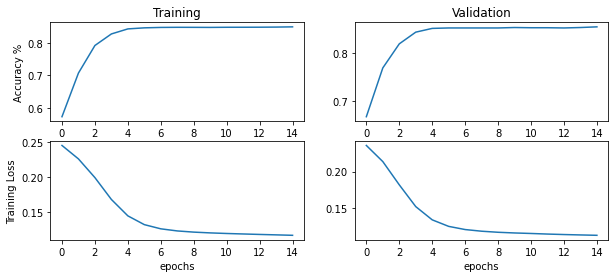

In [32]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history1.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history1.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history1.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history1.history['val_loss'])
plt.xlabel('epochs')

The plot above visualizes the performance of the network on the training data and validation data versus the training iterations for the 10th fold. 

In [33]:
from prettytable import PrettyTable

In [34]:
results = PrettyTable()
results.add_column("Fold", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
results.add_column("Accuracy", VALIDATION_ACCURACY1)
results.add_column("AUC", VALIDATION_AUC1)
print(results)

+------+--------------------+--------------------+
| Fold |      Accuracy      |        AUC         |
+------+--------------------+--------------------+
|  1   | 0.8513388633728027 | 0.924900472164154  |
|  2   | 0.8619575500488281 | 0.9446778297424316 |
|  3   | 0.8379501104354858 | 0.8717092275619507 |
|  4   | 0.8194829225540161 | 0.8808018565177917 |
|  5   | 0.8568790555000305 | 0.9243960976600647 |
|  6   | 0.8453370332717896 | 0.9288032054901123 |
|  7   | 0.8527238965034485 | 0.9194851517677307 |
|  8   | 0.8716528415679932 | 0.9496077299118042 |
|  9   | 0.8628175258636475 | 0.9390691518783569 |
|  10  | 0.8554272651672363 | 0.9135077595710754 |
+------+--------------------+--------------------+


According to the table above, the first fold yielded the best raw results for validation accuracy and AUC, so we will utilize the weights from the model fit in that fold to apply to the test set. 

In [35]:
idx = VALIDATION_ACCURACY1.index(max(VALIDATION_ACCURACY1))
max_fold1 = idx + 1
print("Best Fold:", max_fold1)

Best Fold: 8


In [36]:
model1.load_weights("\saved_models1/model_"+str(max_fold1)+".h5")

y_test = y_test.reshape(-1,1)
    
# get crossed columns
X_test_crossed = X_test[cross_col_df_names1].to_numpy()

# save categorical features
X_test_cat = X_test[categorical_headers].to_numpy() 

# and save off the numeric features
X_test_num = X_test[numeric_headers].to_numpy()

model1.evaluate([X_test_crossed,X_test_cat,X_test_num], y_test)

211/211 [==============================] - 0s 1ms/step - loss: 0.1313 - accuracy: 0.8108 - auc: 0.8962


[0.13132330775260925, 0.8107746839523315, 0.8961811065673828]

In [101]:
yhat_proba = model1.predict([X_test_crossed, X_test_cat, X_test_num])
yhat1 = np.round(yhat_proba)

211/211 [==============================] - 0s 820us/step


### Wide and Deep Network 2

In [37]:
kfold = 1
#kf = KFold(n_splits = 10, shuffle = True, random_state = 24)

VALIDATION_ACCURACY2 = []
VALIDATION_AUC2 = []

for train_index, val_index in kf.split(X_train):
    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]
    y_train1 = y_train[[train_index]].reshape(-1,1)
    y_val = y_train[[val_index]].reshape(-1,1)
    
    # get crossed columns
    X_train_crossed = training_data[cross_col_df_names2].to_numpy()
    X_test_crossed = validation_data[cross_col_df_names2].to_numpy()

    # save categorical features
    X_train_cat = training_data[categorical_headers].to_numpy() 
    X_test_cat = validation_data[categorical_headers].to_numpy() 

    # and save off the numeric features
    X_train_num =  training_data[numeric_headers].to_numpy()
    X_test_num = validation_data[numeric_headers].to_numpy()
    
    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names2):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        crossed_outputs.append(x)
    

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch], name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)
    
    model2 = Model(inputs=[input_crossed,input_cat,input_num], outputs=final_branch)
    
    model2.compile(loss = "mean_squared_error",
                 optimizer = 'sgd', metrics = ['accuracy', 'AUC'])
    
    save_dir = '\saved_models2/'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(kfold), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    history2 = model2.fit([X_train_crossed,X_train_cat,X_train_num], y_train1, epochs=15, batch_size=32, verbose=1,
                        callbacks = [callbacks_list],
                        validation_data = ([X_test_crossed,X_test_cat,X_test_num], y_val))
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model2.load_weights("\saved_models2/model_"+str(kfold)+".h5")

    results = model2.evaluate([X_test_crossed,X_test_cat,X_test_num], y_val)
    results = dict(zip(model2.metrics_names,results))

    VALIDATION_ACCURACY2.append(results['accuracy'])
    VALIDATION_AUC2.append(results['auc'])
    
    tf.keras.backend.clear_session()
    
    kfold += 1

Epoch 1/15
601/610 [============================>.] - ETA: 0s - loss: 0.2430 - accuracy: 0.6028 - auc: 0.6194
Epoch 1: val_accuracy improved from -inf to 0.68006, saving model to \saved_models2/model_1.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.2428 - accuracy: 0.6036 - auc: 0.6209 - val_loss: 0.2313 - val_accuracy: 0.6801 - val_auc: 0.7160
Epoch 2/15
605/610 [============================>.] - ETA: 0s - loss: 0.2168 - accuracy: 0.6908 - auc: 0.7473
Epoch 2: val_accuracy improved from 0.68006 to 0.72946, saving model to \saved_models2/model_1.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2167 - accuracy: 0.6904 - auc: 0.7470 - val_loss: 0.1961 - val_accuracy: 0.7295 - val_auc: 0.7942
Epoch 3/15
573/610 [===========================>..] - ETA: 0s - loss: 0.1835 - accuracy: 0.7343 - auc: 0.8092
Epoch 3: val_accuracy improved from 0.72946 to 0.76777, saving model to \saved_models2/model_1.h5
610/610 [==============================] - 1s 1ms/ste

Epoch 8/15
589/610 [===========================>..] - ETA: 0s - loss: 0.1321 - accuracy: 0.8075 - auc: 0.8953
Epoch 8: val_accuracy improved from 0.79917 to 0.81440, saving model to \saved_models2/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1320 - accuracy: 0.8077 - auc: 0.8955 - val_loss: 0.1250 - val_accuracy: 0.8144 - val_auc: 0.9074
Epoch 9/15
574/610 [===========================>..] - ETA: 0s - loss: 0.1234 - accuracy: 0.8182 - auc: 0.9083
Epoch 9: val_accuracy improved from 0.81440 to 0.82825, saving model to \saved_models2/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1228 - accuracy: 0.8194 - auc: 0.9092 - val_loss: 0.1167 - val_accuracy: 0.8283 - val_auc: 0.9188
Epoch 10/15
601/610 [============================>.] - ETA: 0s - loss: 0.1159 - accuracy: 0.8304 - auc: 0.9187
Epoch 10: val_accuracy improved from 0.82825 to 0.83657, saving model to \saved_models2/model_2.h5
610/610 [==============================] - 1s 1m

593/610 [============================>.] - ETA: 0s - loss: 0.1003 - accuracy: 0.8570 - auc: 0.9379
Epoch 15: val_accuracy improved from 0.83102 to 0.83380, saving model to \saved_models2/model_3.h5
68/68 [==============================] - 0s 1ms/step - loss: 0.1132 - accuracy: 0.8338 - auc: 0.9232
Epoch 1/15
575/610 [===========================>..] - ETA: 0s - loss: 0.2426 - accuracy: 0.5760 - auc: 0.6044
Epoch 1: val_accuracy improved from -inf to 0.59972, saving model to \saved_models2/model_4.h5
610/610 [==============================] - 2s 2ms/step - loss: 0.2424 - accuracy: 0.5773 - auc: 0.6071 - val_loss: 0.2383 - val_accuracy: 0.5997 - val_auc: 0.6564
Epoch 2/15
594/610 [============================>.] - ETA: 0s - loss: 0.2289 - accuracy: 0.6359 - auc: 0.6975
Epoch 2: val_accuracy improved from 0.59972 to 0.66343, saving model to \saved_models2/model_4.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2286 - accuracy: 0.6366 - auc: 0.6987 - val_loss: 0.2190 - v

585/610 [===========================>..] - ETA: 0s - loss: 0.1244 - accuracy: 0.8207 - auc: 0.9057
Epoch 7: val_accuracy improved from 0.81440 to 0.82456, saving model to \saved_models2/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1244 - accuracy: 0.8206 - auc: 0.9056 - val_loss: 0.1231 - val_accuracy: 0.8246 - val_auc: 0.9074
Epoch 8/15
593/610 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.8285 - auc: 0.9135
Epoch 8: val_accuracy improved from 0.82456 to 0.83287, saving model to \saved_models2/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1190 - accuracy: 0.8282 - auc: 0.9135 - val_loss: 0.1182 - val_accuracy: 0.8329 - val_auc: 0.9136
Epoch 9/15
570/610 [===========================>..] - ETA: 0s - loss: 0.1153 - accuracy: 0.8317 - auc: 0.9188
Epoch 9: val_accuracy improved from 0.83287 to 0.83980, saving model to \saved_models2/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss

Epoch 14/15
588/610 [===========================>..] - ETA: 0s - loss: 0.1098 - accuracy: 0.8500 - auc: 0.9304
Epoch 14: val_accuracy did not improve from 0.84257
610/610 [==============================] - 1s 1ms/step - loss: 0.1100 - accuracy: 0.8495 - auc: 0.9301 - val_loss: 0.1126 - val_accuracy: 0.8421 - val_auc: 0.9256
Epoch 15/15
590/610 [============================>.] - ETA: 0s - loss: 0.1081 - accuracy: 0.8518 - auc: 0.9318
Epoch 15: val_accuracy improved from 0.84257 to 0.84949, saving model to \saved_models2/model_6.h5
68/68 [==============================] - 0s 928us/step - loss: 0.1108 - accuracy: 0.8495 - auc: 0.9278
Epoch 1/15
594/610 [============================>.] - ETA: 0s - loss: 0.2459 - accuracy: 0.5512 - auc: 0.5911
Epoch 1: val_accuracy improved from -inf to 0.57987, saving model to \saved_models2/model_7.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2458 - accuracy: 0.5514 - auc: 0.5918 - val_loss: 0.2402 - val_accuracy: 0.5799 - val_auc: 

Epoch 6/15
601/610 [============================>.] - ETA: 0s - loss: 0.2316 - accuracy: 0.6558 - auc: 0.7089
Epoch 6: val_accuracy improved from 0.64728 to 0.66944, saving model to \saved_models2/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2316 - accuracy: 0.6559 - auc: 0.7089 - val_loss: 0.2269 - val_accuracy: 0.6694 - val_auc: 0.7273
Epoch 7/15
579/610 [===========================>..] - ETA: 0s - loss: 0.2198 - accuracy: 0.6818 - auc: 0.7408
Epoch 7: val_accuracy improved from 0.66944 to 0.70683, saving model to \saved_models2/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2196 - accuracy: 0.6818 - auc: 0.7408 - val_loss: 0.2111 - val_accuracy: 0.7068 - val_auc: 0.7624
Epoch 8/15
572/610 [===========================>..] - ETA: 0s - loss: 0.2015 - accuracy: 0.7151 - auc: 0.7826
Epoch 8: val_accuracy improved from 0.70683 to 0.73315, saving model to \saved_models2/model_8.h5
610/610 [==============================] - 1s 1ms/

Epoch 13/15
584/610 [===========================>..] - ETA: 0s - loss: 0.0938 - accuracy: 0.8663 - auc: 0.9452
Epoch 13: val_accuracy did not improve from 0.86697
610/610 [==============================] - 1s 1ms/step - loss: 0.0940 - accuracy: 0.8662 - auc: 0.9451 - val_loss: 0.0940 - val_accuracy: 0.8670 - val_auc: 0.9454
Epoch 14/15
564/610 [==========================>...] - ETA: 0s - loss: 0.0905 - accuracy: 0.8721 - auc: 0.9489
Epoch 14: val_accuracy improved from 0.86697 to 0.86975, saving model to \saved_models2/model_9.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.0904 - accuracy: 0.8727 - auc: 0.9491 - val_loss: 0.0908 - val_accuracy: 0.8697 - val_auc: 0.9484
Epoch 15/15
580/610 [===========================>..] - ETA: 0s - loss: 0.0867 - accuracy: 0.8794 - auc: 0.9531
Epoch 15: val_accuracy improved from 0.86975 to 0.87945, saving model to \saved_models2/model_9.h5
68/68 [==============================] - 0s 1ms/step - loss: 0.0876 - accuracy: 0.8794 - au

Text(0.5, 0, 'epochs')

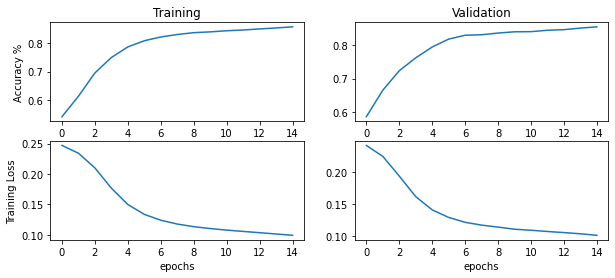

In [38]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history2.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history2.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history2.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history2.history['val_loss'])
plt.xlabel('epochs')

In [39]:
results = PrettyTable()
results.add_column("Fold", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
results.add_column("Accuracy", VALIDATION_ACCURACY2)
results.add_column("AUC", VALIDATION_AUC2)
print(results)

+------+--------------------+--------------------+
| Fold |      Accuracy      |        AUC         |
+------+--------------------+--------------------+
|  1   | 0.8748846054077148 | 0.9543370008468628 |
|  2   | 0.8707294464111328 | 0.9476138353347778 |
|  3   | 0.8337950110435486 | 0.9231528043746948 |
|  4   | 0.8347183465957642 | 0.9249693155288696 |
|  5   | 0.8573406934738159 | 0.9324154853820801 |
|  6   | 0.8494921326637268 | 0.9278420805931091 |
|  7   | 0.8513388633728027 | 0.9325298070907593 |
|  8   | 0.8439520001411438 | 0.9344832301139832 |
|  9   | 0.8794457316398621 | 0.9516303539276123 |
|  10  | 0.854041576385498  | 0.9365116953849792 |
+------+--------------------+--------------------+


In [40]:
idx = VALIDATION_ACCURACY2.index(max(VALIDATION_ACCURACY2))
max_fold2 = idx + 1
print("Best Fold:", max_fold2)

Best Fold: 9


In [41]:
model2.load_weights("\saved_models2/model_"+str(max_fold2)+".h5")
    
# get crossed columns
X_test_crossed = X_test[cross_col_df_names1].to_numpy()

# save categorical features
X_test_cat = X_test[categorical_headers].to_numpy() 

# and save off the numeric features
X_test_num = X_test[numeric_headers].to_numpy()

model2.evaluate([X_test_crossed,X_test_cat,X_test_num], y_test)

211/211 [==============================] - 0s 1ms/step - loss: 0.1366 - accuracy: 0.8008 - auc: 0.8904


[0.13657717406749725, 0.8008310794830322, 0.8904063701629639]

In [100]:
yhat_proba = model2.predict([X_test_crossed, X_test_cat, X_test_num])
yhat2 = np.round(yhat_proba)

211/211 [==============================] - 0s 790us/step


### Wide and Deep Network 3

In [42]:
kfold = 1
#kf = KFold(n_splits = 10, shuffle = True, random_state = 24)

VALIDATION_ACCURACY3 = []
VALIDATION_AUC3 = []

for train_index, val_index in kf.split(X_train):
    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]
    y_train1 = y_train[[train_index]].reshape(-1,1)
    y_val = y_train[[val_index]].reshape(-1,1)
    
    # get crossed columns
    X_train_crossed = training_data[cross_col_df_names3].to_numpy()
    X_test_crossed = validation_data[cross_col_df_names3].to_numpy()

    # save categorical features
    X_train_cat = training_data[categorical_headers].to_numpy() 
    X_test_cat = validation_data[categorical_headers].to_numpy() 

    # and save off the numeric features
    X_train_num =  training_data[numeric_headers].to_numpy()
    X_test_num = validation_data[numeric_headers].to_numpy()
    
    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names3):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        crossed_outputs.append(x)
    

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch], name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)
    
    model3 = Model(inputs=[input_crossed,input_cat,input_num], outputs=final_branch)
    
    model3.compile(loss = "mean_squared_error",
                 optimizer = 'sgd', metrics = ['accuracy', 'AUC'])
    
    save_dir = '\saved_models3/'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(kfold), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    history3 = model3.fit([X_train_crossed,X_train_cat,X_train_num], y_train1, epochs=15, batch_size=32, verbose=1,
                        callbacks = [callbacks_list],
                        validation_data = ([X_test_crossed,X_test_cat,X_test_num], y_val))
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model3.load_weights("\saved_models3/model_"+str(kfold)+".h5")

    results = model3.evaluate([X_test_crossed,X_test_cat,X_test_num], y_val)
    results = dict(zip(model3.metrics_names,results))

    VALIDATION_ACCURACY3.append(results['accuracy'])
    VALIDATION_AUC3.append(results['auc'])
    
    tf.keras.backend.clear_session()
    
    kfold += 1

Epoch 1/15
609/610 [============================>.] - ETA: 0s - loss: 0.2484 - accuracy: 0.5461 - auc: 0.5868
Epoch 1: val_accuracy improved from -inf to 0.64174, saving model to \saved_models3/model_1.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.2484 - accuracy: 0.5462 - auc: 0.5868 - val_loss: 0.2418 - val_accuracy: 0.6417 - val_auc: 0.6883
Epoch 2/15
578/610 [===========================>..] - ETA: 0s - loss: 0.2361 - accuracy: 0.6776 - auc: 0.7448
Epoch 2: val_accuracy improved from 0.64174 to 0.69852, saving model to \saved_models3/model_1.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2357 - accuracy: 0.6784 - auc: 0.7465 - val_loss: 0.2282 - val_accuracy: 0.6985 - val_auc: 0.7762
Epoch 3/15
610/610 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.7240 - auc: 0.7993
Epoch 3: val_accuracy improved from 0.69852 to 0.73546, saving model to \saved_models3/model_1.h5
610/610 [==============================] - 1s 1ms/ste

Epoch 8/15
578/610 [===========================>..] - ETA: 0s - loss: 0.1276 - accuracy: 0.8248 - auc: 0.9037
Epoch 8: val_accuracy improved from 0.82410 to 0.83149, saving model to \saved_models3/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1274 - accuracy: 0.8251 - auc: 0.9040 - val_loss: 0.1211 - val_accuracy: 0.8315 - val_auc: 0.9136
Epoch 9/15
566/610 [==========================>...] - ETA: 0s - loss: 0.1215 - accuracy: 0.8320 - auc: 0.9111
Epoch 9: val_accuracy improved from 0.83149 to 0.83749, saving model to \saved_models3/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1207 - accuracy: 0.8339 - auc: 0.9119 - val_loss: 0.1159 - val_accuracy: 0.8375 - val_auc: 0.9196
Epoch 10/15
580/610 [===========================>..] - ETA: 0s - loss: 0.1165 - accuracy: 0.8393 - auc: 0.9169
Epoch 10: val_accuracy improved from 0.83749 to 0.83980, saving model to \saved_models3/model_2.h5
610/610 [==============================] - 1s 1m

582/610 [===========================>..] - ETA: 0s - loss: 0.0973 - accuracy: 0.8625 - auc: 0.9413
Epoch 15: val_accuracy improved from 0.83980 to 0.84488, saving model to \saved_models3/model_3.h5
68/68 [==============================] - 0s 943us/step - loss: 0.1070 - accuracy: 0.8449 - auc: 0.9316
Epoch 1/15
581/610 [===========================>..] - ETA: 0s - loss: 0.2430 - accuracy: 0.6369 - auc: 0.6961
Epoch 1: val_accuracy improved from -inf to 0.73823, saving model to \saved_models3/model_4.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2426 - accuracy: 0.6425 - auc: 0.7011 - val_loss: 0.2354 - val_accuracy: 0.7382 - val_auc: 0.8046
Epoch 2/15
583/610 [===========================>..] - ETA: 0s - loss: 0.2263 - accuracy: 0.7685 - auc: 0.8372
Epoch 2: val_accuracy improved from 0.73823 to 0.77747, saving model to \saved_models3/model_4.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2258 - accuracy: 0.7701 - auc: 0.8380 - val_loss: 0.2166 -

610/610 [==============================] - 1s 2ms/step - loss: 0.1244 - accuracy: 0.8230 - auc: 0.9076 - val_loss: 0.1190 - val_accuracy: 0.8296 - val_auc: 0.9146
Epoch 8/15
602/610 [============================>.] - ETA: 0s - loss: 0.1186 - accuracy: 0.8317 - auc: 0.9152
Epoch 8: val_accuracy improved from 0.82964 to 0.83887, saving model to \saved_models3/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1184 - accuracy: 0.8319 - auc: 0.9154 - val_loss: 0.1149 - val_accuracy: 0.8389 - val_auc: 0.9195
Epoch 9/15
570/610 [===========================>..] - ETA: 0s - loss: 0.1151 - accuracy: 0.8343 - auc: 0.9196
Epoch 9: val_accuracy improved from 0.83887 to 0.84164, saving model to \saved_models3/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1146 - accuracy: 0.8355 - auc: 0.9202 - val_loss: 0.1114 - val_accuracy: 0.8416 - val_auc: 0.9243
Epoch 10/15
580/610 [===========================>..] - ETA: 0s - loss: 0.1114 - accuracy: 0.840

Epoch 15/15
598/610 [============================>.] - ETA: 0s - loss: 0.1105 - accuracy: 0.8499 - auc: 0.9235
Epoch 15: val_accuracy did not improve from 0.84534
68/68 [==============================] - 0s 1ms/step - loss: 0.1130 - accuracy: 0.8453 - auc: 0.9204
Epoch 1/15
576/610 [===========================>..] - ETA: 0s - loss: 0.2468 - accuracy: 0.5649 - auc: 0.5825
Epoch 1: val_accuracy improved from -inf to 0.64589, saving model to \saved_models3/model_7.h5
610/610 [==============================] - 2s 2ms/step - loss: 0.2464 - accuracy: 0.5686 - auc: 0.5882 - val_loss: 0.2391 - val_accuracy: 0.6459 - val_auc: 0.6941
Epoch 2/15
598/610 [============================>.] - ETA: 0s - loss: 0.2304 - accuracy: 0.6752 - auc: 0.7263
Epoch 2: val_accuracy improved from 0.64589 to 0.69252, saving model to \saved_models3/model_7.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2301 - accuracy: 0.6762 - auc: 0.7274 - val_loss: 0.2179 - val_accuracy: 0.6925 - val_auc: 0.75

Epoch 7/15
606/610 [============================>.] - ETA: 0s - loss: 0.1204 - accuracy: 0.8316 - auc: 0.9111
Epoch 7: val_accuracy improved from 0.82041 to 0.82918, saving model to \saved_models3/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1203 - accuracy: 0.8317 - auc: 0.9112 - val_loss: 0.1154 - val_accuracy: 0.8292 - val_auc: 0.9190
Epoch 8/15
582/610 [===========================>..] - ETA: 0s - loss: 0.1153 - accuracy: 0.8382 - auc: 0.9174
Epoch 8: val_accuracy improved from 0.82918 to 0.83795, saving model to \saved_models3/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1155 - accuracy: 0.8377 - auc: 0.9171 - val_loss: 0.1121 - val_accuracy: 0.8380 - val_auc: 0.9231
Epoch 9/15
574/610 [===========================>..] - ETA: 0s - loss: 0.1133 - accuracy: 0.8418 - auc: 0.9202
Epoch 9: val_accuracy improved from 0.83795 to 0.84580, saving model to \saved_models3/model_8.h5
610/610 [==============================] - 1s 1ms/

582/610 [===========================>..] - ETA: 0s - loss: 0.0954 - accuracy: 0.8643 - auc: 0.9440
Epoch 14: val_accuracy did not improve from 0.86605
610/610 [==============================] - 1s 1ms/step - loss: 0.0952 - accuracy: 0.8647 - auc: 0.9441 - val_loss: 0.0932 - val_accuracy: 0.8647 - val_auc: 0.9455
Epoch 15/15
586/610 [===========================>..] - ETA: 0s - loss: 0.0927 - accuracy: 0.8693 - auc: 0.9471
Epoch 15: val_accuracy improved from 0.86605 to 0.86928, saving model to \saved_models3/model_9.h5
68/68 [==============================] - 0s 1ms/step - loss: 0.0907 - accuracy: 0.8693 - auc: 0.9484
Epoch 1/15
609/610 [============================>.] - ETA: 0s - loss: 0.2474 - accuracy: 0.5270 - auc: 0.5566
Epoch 1: val_accuracy improved from -inf to 0.55289, saving model to \saved_models3/model_10.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.2474 - accuracy: 0.5271 - auc: 0.5567 - val_loss: 0.2427 - val_accuracy: 0.5529 - val_auc: 0.6712
Epoch 

Text(0.5, 0, 'epochs')

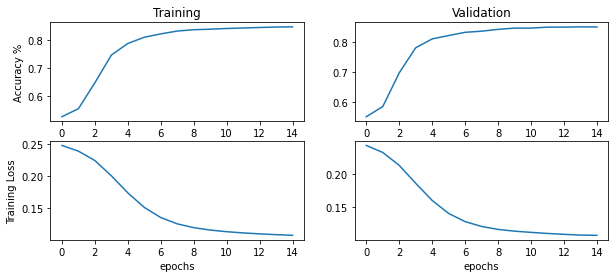

In [43]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history3.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history3.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history3.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history3.history['val_loss'])
plt.xlabel('epochs')

In [44]:
results = PrettyTable()
results.add_column("Fold", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
results.add_column("Accuracy", VALIDATION_ACCURACY3)
results.add_column("AUC", VALIDATION_AUC3)
print(results)

+------+--------------------+--------------------+
| Fold |      Accuracy      |        AUC         |
+------+--------------------+--------------------+
|  1   | 0.8578023910522461 | 0.9286025762557983 |
|  2   | 0.8504155278205872 | 0.9310996532440186 |
|  3   | 0.8448753356933594 | 0.931586503982544  |
|  4   | 0.8180978894233704 | 0.8994466066360474 |
|  5   | 0.8591874241828918 | 0.9380176663398743 |
|  6   | 0.8453370332717896 | 0.9204404354095459 |
|  7   | 0.8421052694320679 | 0.9210142493247986 |
|  8   | 0.8545706272125244 | 0.9357939958572388 |
|  9   | 0.8692840933799744 | 0.9483535885810852 |
|  10  | 0.8494226336479187 | 0.927574098110199  |
+------+--------------------+--------------------+


In [45]:
idx = VALIDATION_ACCURACY3.index(max(VALIDATION_ACCURACY3))
max_fold3 = idx + 1
print("Best Fold:", max_fold3)

Best Fold: 9


In [46]:
model3.load_weights("\saved_models3/model_"+str(max_fold3)+".h5")
    
# get crossed columns
X_test_crossed = X_test[cross_col_df_names1].to_numpy()

# save categorical features
X_test_cat = X_test[categorical_headers].to_numpy() 

# and save off the numeric features
X_test_num = X_test[numeric_headers].to_numpy()

model3.evaluate([X_test_crossed,X_test_cat,X_test_num], y_test)

211/211 [==============================] - 0s 934us/step - loss: 0.1298 - accuracy: 0.8109 - auc: 0.8988


[0.1297912746667862, 0.8109230995178223, 0.8987582921981812]

In [99]:
yhat_proba = model3.predict([X_test_crossed, X_test_cat, X_test_num])
yhat3 = np.round(yhat_proba)

211/211 [==============================] - 0s 773us/step


### Wide and Deep Network 1 - More Layers

In [47]:
kfold = 1
#kf = KFold(n_splits = 10, shuffle = True, random_state = 24)

VALIDATION_ACCURACY11 = []
VALIDATION_AUC11 = []

for train_index, val_index in kf.split(X_train):
    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]
    y_train1 = y_train[[train_index]].reshape(-1,1)
    y_val = y_train[[val_index]].reshape(-1,1)
    
    # get crossed columns
    X_train_crossed = training_data[cross_col_df_names1].to_numpy()
    X_test_crossed = validation_data[cross_col_df_names1].to_numpy()

    # save categorical features
    X_train_cat = training_data[categorical_headers].to_numpy() 
    X_test_cat = validation_data[categorical_headers].to_numpy() 

    # and save off the numeric features
    X_train_num =  training_data[numeric_headers].to_numpy()
    X_test_num = validation_data[numeric_headers].to_numpy()
    
    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names1):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        crossed_outputs.append(x)
    

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep4')(deep_branch) # added this!
    
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch], name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)
    
    model11 = Model(inputs=[input_crossed,input_cat,input_num], outputs=final_branch)
    
    model11.compile(loss = "mean_squared_error",
                 optimizer = 'sgd', metrics = ['accuracy', 'AUC'])
    
    save_dir = '\saved_models1_1/'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(kfold), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    history11 = model11.fit([X_train_crossed,X_train_cat,X_train_num], y_train1, epochs=15, batch_size=32, verbose=1,
                        callbacks = [callbacks_list],
                        validation_data = ([X_test_crossed,X_test_cat,X_test_num], y_val))
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model11.load_weights("\saved_models1_1/model_"+str(kfold)+".h5")

    results = model11.evaluate([X_test_crossed,X_test_cat,X_test_num], y_val)
    results = dict(zip(model11.metrics_names,results))

    VALIDATION_ACCURACY11.append(results['accuracy'])
    VALIDATION_AUC11.append(results['auc'])
    
    tf.keras.backend.clear_session()
    
    kfold += 1

Epoch 1/15
586/610 [===========================>..] - ETA: 0s - loss: 0.2424 - accuracy: 0.5528 - auc: 0.6339
Epoch 1: val_accuracy improved from -inf to 0.61173, saving model to \saved_models1_1/model_1.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.2420 - accuracy: 0.5544 - auc: 0.6389 - val_loss: 0.2317 - val_accuracy: 0.6117 - val_auc: 0.7618
Epoch 2/15
580/610 [===========================>..] - ETA: 0s - loss: 0.2227 - accuracy: 0.7007 - auc: 0.7904
Epoch 2: val_accuracy improved from 0.61173 to 0.77193, saving model to \saved_models1_1/model_1.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2224 - accuracy: 0.7026 - auc: 0.7908 - val_loss: 0.2086 - val_accuracy: 0.7719 - val_auc: 0.8290
Epoch 3/15
592/610 [============================>.] - ETA: 0s - loss: 0.1968 - accuracy: 0.7854 - auc: 0.8396
Epoch 3: val_accuracy improved from 0.77193 to 0.80425, saving model to \saved_models1_1/model_1.h5
610/610 [==============================] - 1s 1

Epoch 9/15
579/610 [===========================>..] - ETA: 0s - loss: 0.1207 - accuracy: 0.8467 - auc: 0.8980
Epoch 9: val_accuracy did not improve from 0.85180
610/610 [==============================] - 1s 1ms/step - loss: 0.1206 - accuracy: 0.8468 - auc: 0.8979 - val_loss: 0.1188 - val_accuracy: 0.8500 - val_auc: 0.9017
Epoch 10/15
606/610 [============================>.] - ETA: 0s - loss: 0.1201 - accuracy: 0.8464 - auc: 0.8996
Epoch 10: val_accuracy did not improve from 0.85180
610/610 [==============================] - 1s 1ms/step - loss: 0.1200 - accuracy: 0.8464 - auc: 0.8998 - val_loss: 0.1183 - val_accuracy: 0.8500 - val_auc: 0.9030
Epoch 11/15
574/610 [===========================>..] - ETA: 0s - loss: 0.1190 - accuracy: 0.8479 - auc: 0.9022
Epoch 11: val_accuracy did not improve from 0.85180
610/610 [==============================] - 1s 1ms/step - loss: 0.1195 - accuracy: 0.8471 - auc: 0.9015 - val_loss: 0.1180 - val_accuracy: 0.8500 - val_auc: 0.9039
Epoch 12/15
571/610 [===

Epoch 3/15
569/610 [==========================>...] - ETA: 0s - loss: 0.1594 - accuracy: 0.8512 - auc: 0.8743
Epoch 3: val_accuracy improved from 0.81625 to 0.81948, saving model to \saved_models1_1/model_4.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1588 - accuracy: 0.8506 - auc: 0.8737 - val_loss: 0.1576 - val_accuracy: 0.8195 - val_auc: 0.8541
Epoch 4/15
603/610 [============================>.] - ETA: 0s - loss: 0.1379 - accuracy: 0.8506 - auc: 0.8766
Epoch 4: val_accuracy improved from 0.81948 to 0.82087, saving model to \saved_models1_1/model_4.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1378 - accuracy: 0.8507 - auc: 0.8768 - val_loss: 0.1464 - val_accuracy: 0.8209 - val_auc: 0.8583
Epoch 5/15
571/610 [===========================>..] - ETA: 0s - loss: 0.1286 - accuracy: 0.8505 - auc: 0.8805
Epoch 5: val_accuracy did not improve from 0.82087
610/610 [==============================] - 1s 1ms/step - loss: 0.1283 - accuracy: 0.8507 - au

Epoch 11/15
575/610 [===========================>..] - ETA: 0s - loss: 0.1163 - accuracy: 0.8448 - auc: 0.9135
Epoch 11: val_accuracy improved from 0.85826 to 0.85873, saving model to \saved_models1_1/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1156 - accuracy: 0.8457 - auc: 0.9145 - val_loss: 0.1103 - val_accuracy: 0.8587 - val_auc: 0.9192
Epoch 12/15
574/610 [===========================>..] - ETA: 0s - loss: 0.1141 - accuracy: 0.8466 - auc: 0.9172
Epoch 12: val_accuracy did not improve from 0.85873
610/610 [==============================] - 1s 1ms/step - loss: 0.1145 - accuracy: 0.8460 - auc: 0.9165 - val_loss: 0.1094 - val_accuracy: 0.8583 - val_auc: 0.9207
Epoch 13/15
605/610 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.8470 - auc: 0.9183
Epoch 13: val_accuracy improved from 0.85873 to 0.86057, saving model to \saved_models1_1/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1136 - accuracy: 0.846

578/610 [===========================>..] - ETA: 0s - loss: 0.1753 - accuracy: 0.7607 - auc: 0.8420
Epoch 3: val_accuracy improved from 0.74377 to 0.78209, saving model to \saved_models1_1/model_7.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1747 - accuracy: 0.7614 - auc: 0.8426 - val_loss: 0.1613 - val_accuracy: 0.7821 - val_auc: 0.8631
Epoch 4/15
575/610 [===========================>..] - ETA: 0s - loss: 0.1503 - accuracy: 0.7977 - auc: 0.8779
Epoch 4: val_accuracy improved from 0.78209 to 0.81671, saving model to \saved_models1_1/model_7.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1496 - accuracy: 0.7989 - auc: 0.8789 - val_loss: 0.1405 - val_accuracy: 0.8167 - val_auc: 0.8892
Epoch 5/15
570/610 [===========================>..] - ETA: 0s - loss: 0.1342 - accuracy: 0.8213 - auc: 0.8965
Epoch 5: val_accuracy improved from 0.81671 to 0.82595, saving model to \saved_models1_1/model_7.h5
610/610 [==============================] - 1s 1ms/step 

564/610 [==========================>...] - ETA: 0s - loss: 0.1114 - accuracy: 0.8462 - auc: 0.9222
Epoch 10: val_accuracy improved from 0.86242 to 0.86380, saving model to \saved_models1_1/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1113 - accuracy: 0.8467 - auc: 0.9221 - val_loss: 0.1051 - val_accuracy: 0.8638 - val_auc: 0.9299
Epoch 11/15
593/610 [============================>.] - ETA: 0s - loss: 0.1103 - accuracy: 0.8474 - auc: 0.9235
Epoch 11: val_accuracy did not improve from 0.86380
610/610 [==============================] - 1s 1ms/step - loss: 0.1104 - accuracy: 0.8476 - auc: 0.9236 - val_loss: 0.1043 - val_accuracy: 0.8620 - val_auc: 0.9310
Epoch 12/15
567/610 [==========================>...] - ETA: 0s - loss: 0.1100 - accuracy: 0.8465 - auc: 0.9245
Epoch 12: val_accuracy did not improve from 0.86380
610/610 [==============================] - 1s 1ms/step - loss: 0.1095 - accuracy: 0.8477 - auc: 0.9249 - val_loss: 0.1029 - val_accuracy: 0.8638 - v

Epoch 3/15
570/610 [===========================>..] - ETA: 0s - loss: 0.1986 - accuracy: 0.7470 - auc: 0.8198
Epoch 3: val_accuracy improved from 0.73303 to 0.76859, saving model to \saved_models1_1/model_10.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1978 - accuracy: 0.7476 - auc: 0.8208 - val_loss: 0.1798 - val_accuracy: 0.7686 - val_auc: 0.8475
Epoch 4/15
573/610 [===========================>..] - ETA: 0s - loss: 0.1690 - accuracy: 0.7824 - auc: 0.8583
Epoch 4: val_accuracy improved from 0.76859 to 0.80462, saving model to \saved_models1_1/model_10.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1687 - accuracy: 0.7822 - auc: 0.8577 - val_loss: 0.1544 - val_accuracy: 0.8046 - val_auc: 0.8756
Epoch 5/15
599/610 [============================>.] - ETA: 0s - loss: 0.1472 - accuracy: 0.8068 - auc: 0.8830
Epoch 5: val_accuracy improved from 0.80462 to 0.81940, saving model to \saved_models1_1/model_10.h5
610/610 [==============================] 

Text(0.5, 0, 'epochs')

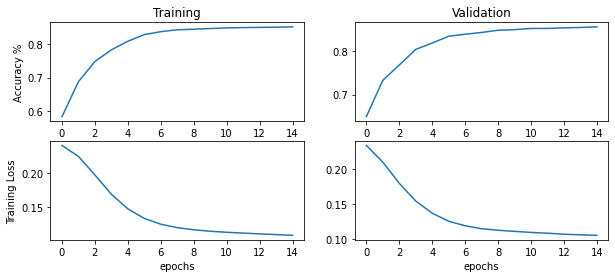

In [48]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history11.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history11.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history11.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history11.history['val_loss'])
plt.xlabel('epochs')

In [49]:
results = PrettyTable()
results.add_column("Fold", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
results.add_column("Accuracy", VALIDATION_ACCURACY11)
results.add_column("AUC", VALIDATION_AUC11)
print(results)

+------+--------------------+--------------------+
| Fold |      Accuracy      |        AUC         |
+------+--------------------+--------------------+
|  1   | 0.8471837639808655 | 0.9153054356575012 |
|  2   | 0.8518005609512329 | 0.8927249312400818 |
|  3   | 0.8402585387229919 | 0.8869119882583618 |
|  4   | 0.8222529888153076 | 0.8762747049331665 |
|  5   | 0.8605724573135376 | 0.9220743179321289 |
|  6   | 0.8522622585296631 | 0.9196503162384033 |
|  7   | 0.8522622585296631 | 0.927057147026062  |
|  8   | 0.8651893138885498 | 0.9351232051849365 |
|  9   | 0.8521940112113953 | 0.9147030115127563 |
|  10  | 0.8568129539489746 | 0.9307849407196045 |
+------+--------------------+--------------------+


In [50]:
idx = VALIDATION_ACCURACY11.index(max(VALIDATION_ACCURACY11))
max_fold11 = idx + 1
print("Best Fold:", max_fold11)

Best Fold: 8


In [51]:
model11.load_weights("\saved_models1_1/model_"+str(max_fold11)+".h5")
    
# get crossed columns
X_test_crossed = X_test[cross_col_df_names1].to_numpy()

# save categorical features
X_test_cat = X_test[categorical_headers].to_numpy() 

# and save off the numeric features
X_test_num = X_test[numeric_headers].to_numpy()

model11.evaluate([X_test_crossed,X_test_cat,X_test_num], y_test)

211/211 [==============================] - 0s 944us/step - loss: 0.1392 - accuracy: 0.8042 - auc: 0.8878


[0.13915589451789856, 0.8042445778846741, 0.8877599239349365]

In [98]:
yhat_proba = model11.predict([X_test_crossed, X_test_cat, X_test_num])
yhat11 = np.round(yhat_proba)

211/211 [==============================] - 0s 819us/step


### Wide and Deep Network 1 - Even More Layers

In [52]:
kfold = 1
#kf = KFold(n_splits = 10, shuffle = True, random_state = 24)

VALIDATION_ACCURACY12 = []
VALIDATION_AUC12 = []

for train_index, val_index in kf.split(X_train):
    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]
    y_train1 = y_train[[train_index]].reshape(-1,1)
    y_val = y_train[[val_index]].reshape(-1,1)
    
    # get crossed columns
    X_train_crossed = training_data[cross_col_df_names1].to_numpy()
    X_test_crossed = validation_data[cross_col_df_names1].to_numpy()

    # save categorical features
    X_train_cat = training_data[categorical_headers].to_numpy() 
    X_test_cat = validation_data[categorical_headers].to_numpy() 

    # and save off the numeric features
    X_train_num =  training_data[numeric_headers].to_numpy()
    X_test_num = validation_data[numeric_headers].to_numpy()
    
    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names1):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        crossed_outputs.append(x)
    

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep4')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep5')(deep_branch) # added this!
    
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch], name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)
    
    model12 = Model(inputs=[input_crossed,input_cat,input_num], outputs=final_branch)
    
    model12.compile(loss = "mean_squared_error",
                 optimizer = 'sgd', metrics = ['accuracy', 'AUC'])
    
    save_dir = '\saved_models1_2/'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(kfold), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    history12 = model12.fit([X_train_crossed,X_train_cat,X_train_num], y_train1, epochs=15, batch_size=32, verbose=1,
                        callbacks = [callbacks_list],
                        validation_data = ([X_test_crossed,X_test_cat,X_test_num], y_val))
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model12.load_weights("\saved_models1_2/model_"+str(kfold)+".h5")

    results = model12.evaluate([X_test_crossed,X_test_cat,X_test_num], y_val)
    results = dict(zip(model12.metrics_names,results))

    VALIDATION_ACCURACY12.append(results['accuracy'])
    VALIDATION_AUC12.append(results['auc'])
    
    tf.keras.backend.clear_session()
    
    kfold += 1

Epoch 1/15
566/610 [==========================>...] - ETA: 0s - loss: 0.2423 - accuracy: 0.5873 - auc: 0.6480
Epoch 1: val_accuracy improved from -inf to 0.68098, saving model to \saved_models1_2/model_1.h5
610/610 [==============================] - 2s 2ms/step - loss: 0.2414 - accuracy: 0.5938 - auc: 0.6574 - val_loss: 0.2284 - val_accuracy: 0.6810 - val_auc: 0.7711
Epoch 2/15
581/610 [===========================>..] - ETA: 0s - loss: 0.2112 - accuracy: 0.7249 - auc: 0.8127
Epoch 2: val_accuracy improved from 0.68098 to 0.74931, saving model to \saved_models1_2/model_1.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2105 - accuracy: 0.7249 - auc: 0.8116 - val_loss: 0.1905 - val_accuracy: 0.7493 - val_auc: 0.8346
Epoch 3/15
606/610 [============================>.] - ETA: 0s - loss: 0.1744 - accuracy: 0.7681 - auc: 0.8518
Epoch 3: val_accuracy improved from 0.74931 to 0.78024, saving model to \saved_models1_2/model_1.h5
610/610 [==============================] - 1s 1

Epoch 8/15
610/610 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.8413 - auc: 0.9120
Epoch 8: val_accuracy improved from 0.84626 to 0.84765, saving model to \saved_models1_2/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1180 - accuracy: 0.8413 - auc: 0.9120 - val_loss: 0.1140 - val_accuracy: 0.8476 - val_auc: 0.9197
Epoch 9/15
590/610 [============================>.] - ETA: 0s - loss: 0.1151 - accuracy: 0.8437 - auc: 0.9159
Epoch 9: val_accuracy improved from 0.84765 to 0.84857, saving model to \saved_models1_2/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1151 - accuracy: 0.8437 - auc: 0.9158 - val_loss: 0.1116 - val_accuracy: 0.8486 - val_auc: 0.9224
Epoch 10/15
573/610 [===========================>..] - ETA: 0s - loss: 0.1138 - accuracy: 0.8445 - auc: 0.9180
Epoch 10: val_accuracy improved from 0.84857 to 0.85226, saving model to \saved_models1_2/model_2.h5
610/610 [==============================] -

68/68 [==============================] - 0s 1ms/step - loss: 0.1273 - accuracy: 0.8393 - auc: 0.8852
Epoch 1/15
604/610 [============================>.] - ETA: 0s - loss: 0.2381 - accuracy: 0.5974 - auc: 0.7643
Epoch 1: val_accuracy improved from -inf to 0.67313, saving model to \saved_models1_2/model_4.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.2381 - accuracy: 0.5974 - auc: 0.7645 - val_loss: 0.2298 - val_accuracy: 0.6731 - val_auc: 0.8234
Epoch 2/15
595/610 [============================>.] - ETA: 0s - loss: 0.2144 - accuracy: 0.7693 - auc: 0.8573
Epoch 2: val_accuracy improved from 0.67313 to 0.78255, saving model to \saved_models1_2/model_4.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2140 - accuracy: 0.7706 - auc: 0.8582 - val_loss: 0.2032 - val_accuracy: 0.7825 - val_auc: 0.8499
Epoch 3/15
603/610 [============================>.] - ETA: 0s - loss: 0.1823 - accuracy: 0.8299 - auc: 0.8721
Epoch 3: val_accuracy improved from 0.78255 to

610/610 [==============================] - 1s 1ms/step - loss: 0.1210 - accuracy: 0.8440 - auc: 0.9070 - val_loss: 0.1187 - val_accuracy: 0.8486 - val_auc: 0.9091
Epoch 9/15
595/610 [============================>.] - ETA: 0s - loss: 0.1180 - accuracy: 0.8457 - auc: 0.9106
Epoch 9: val_accuracy did not improve from 0.84857
610/610 [==============================] - 1s 1ms/step - loss: 0.1180 - accuracy: 0.8456 - auc: 0.9106 - val_loss: 0.1165 - val_accuracy: 0.8486 - val_auc: 0.9119
Epoch 10/15
604/610 [============================>.] - ETA: 0s - loss: 0.1163 - accuracy: 0.8463 - auc: 0.9131
Epoch 10: val_accuracy improved from 0.84857 to 0.85365, saving model to \saved_models1_2/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1161 - accuracy: 0.8466 - auc: 0.9132 - val_loss: 0.1141 - val_accuracy: 0.8536 - val_auc: 0.9150
Epoch 11/15
591/610 [============================>.] - ETA: 0s - loss: 0.1150 - accuracy: 0.8471 - auc: 0.9152
Epoch 11: val_accuracy did 

606/610 [============================>.] - ETA: 0s - loss: 0.2337 - accuracy: 0.6739 - auc: 0.7656
Epoch 1: val_accuracy improved from -inf to 0.75069, saving model to \saved_models1_2/model_7.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.2336 - accuracy: 0.6742 - auc: 0.7660 - val_loss: 0.2185 - val_accuracy: 0.7507 - val_auc: 0.8304
Epoch 2/15
609/610 [============================>.] - ETA: 0s - loss: 0.2034 - accuracy: 0.7807 - auc: 0.8449
Epoch 2: val_accuracy improved from 0.75069 to 0.80240, saving model to \saved_models1_2/model_7.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2033 - accuracy: 0.7807 - auc: 0.8450 - val_loss: 0.1862 - val_accuracy: 0.8024 - val_auc: 0.8593
Epoch 3/15
596/610 [============================>.] - ETA: 0s - loss: 0.1715 - accuracy: 0.8162 - auc: 0.8686
Epoch 3: val_accuracy improved from 0.80240 to 0.83010, saving model to \saved_models1_2/model_7.h5
610/610 [==============================] - 1s 1ms/step - l

Epoch 9/15
603/610 [============================>.] - ETA: 0s - loss: 0.1187 - accuracy: 0.8452 - auc: 0.9048
Epoch 9: val_accuracy did not improve from 0.85873
610/610 [==============================] - 1s 1ms/step - loss: 0.1187 - accuracy: 0.8454 - auc: 0.9048 - val_loss: 0.1129 - val_accuracy: 0.8573 - val_auc: 0.9104
Epoch 10/15
599/610 [============================>.] - ETA: 0s - loss: 0.1176 - accuracy: 0.8464 - auc: 0.9068
Epoch 10: val_accuracy did not improve from 0.85873
610/610 [==============================] - 1s 1ms/step - loss: 0.1178 - accuracy: 0.8457 - auc: 0.9066 - val_loss: 0.1122 - val_accuracy: 0.8573 - val_auc: 0.9122
Epoch 11/15
565/610 [==========================>...] - ETA: 0s - loss: 0.1174 - accuracy: 0.8452 - auc: 0.9085
Epoch 11: val_accuracy did not improve from 0.85873
610/610 [==============================] - 1s 1ms/step - loss: 0.1170 - accuracy: 0.8461 - auc: 0.9089 - val_loss: 0.1118 - val_accuracy: 0.8569 - val_auc: 0.9136
Epoch 12/15
605/610 [===

Epoch 3/15
580/610 [===========================>..] - ETA: 0s - loss: 0.1825 - accuracy: 0.8430 - auc: 0.8720
Epoch 3: val_accuracy improved from 0.84804 to 0.84942, saving model to \saved_models1_2/model_10.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1818 - accuracy: 0.8431 - auc: 0.8715 - val_loss: 0.1620 - val_accuracy: 0.8494 - val_auc: 0.8867
Epoch 4/15
579/610 [===========================>..] - ETA: 0s - loss: 0.1529 - accuracy: 0.8444 - auc: 0.8769
Epoch 4: val_accuracy did not improve from 0.84942
610/610 [==============================] - 1s 1ms/step - loss: 0.1523 - accuracy: 0.8443 - auc: 0.8770 - val_loss: 0.1384 - val_accuracy: 0.8490 - val_auc: 0.8913
Epoch 5/15
575/610 [===========================>..] - ETA: 0s - loss: 0.1363 - accuracy: 0.8443 - auc: 0.8808
Epoch 5: val_accuracy improved from 0.84942 to 0.84988, saving model to \saved_models1_2/model_10.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1360 - accuracy: 0.8444 - 

Text(0.5, 0, 'epochs')

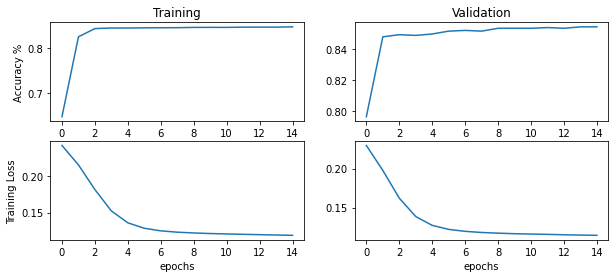

In [53]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history12.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history12.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history12.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history12.history['val_loss'])
plt.xlabel('epochs')

In [54]:
results = PrettyTable()
results.add_column("Fold", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
results.add_column("Accuracy", VALIDATION_ACCURACY12)
results.add_column("AUC", VALIDATION_AUC12)
print(results)

+------+--------------------+--------------------+
| Fold |      Accuracy      |        AUC         |
+------+--------------------+--------------------+
|  1   | 0.8522622585296631 | 0.9311910271644592 |
|  2   | 0.8559556603431702 | 0.933461606502533  |
|  3   | 0.8393352031707764 | 0.885219931602478  |
|  4   | 0.8199446201324463 | 0.8713917136192322 |
|  5   | 0.8550323247909546 | 0.9221787452697754 |
|  6   | 0.8508771657943726 | 0.8838908672332764 |
|  7   | 0.8508771657943726 | 0.9060196876525879 |
|  8   | 0.8587257862091064 | 0.9061406254768372 |
|  9   | 0.850808322429657  | 0.890036940574646  |
|  10  | 0.8545034527778625 | 0.9094327688217163 |
+------+--------------------+--------------------+


In [55]:
idx = VALIDATION_ACCURACY12.index(max(VALIDATION_ACCURACY12))
max_fold12 = idx + 1
print("Best Fold:", max_fold12)

Best Fold: 8


In [56]:
model12.load_weights("\saved_models1_2/model_"+str(max_fold12)+".h5")
    
# get crossed columns
X_test_crossed = X_test[cross_col_df_names1].to_numpy()

# save categorical features
X_test_cat = X_test[categorical_headers].to_numpy() 

# and save off the numeric features
X_test_num = X_test[numeric_headers].to_numpy()

model12.evaluate([X_test_crossed,X_test_cat,X_test_num], y_test)

211/211 [==============================] - 0s 1000us/step - loss: 0.1466 - accuracy: 0.8031 - auc: 0.8629


[0.146638423204422, 0.8030573129653931, 0.8628939986228943]

In [97]:
yhat_proba = model12.predict([X_test_crossed, X_test_cat, X_test_num])
yhat12 = np.round(yhat_proba)

211/211 [==============================] - 0s 788us/step


### Compare Generalization Performance for W/D 1 - McNemar's Test

In [121]:
from itertools import chain

In [130]:
wd1 = pd.DataFrame()
wd1['Deep'] = list(chain.from_iterable(yhat1))
wd1['Deeper'] = list(chain.from_iterable(yhat11))
wd1['Deepest'] = list(chain.from_iterable(yhat12))
wd1['Truth'] = list(chain.from_iterable(y_test))

In [137]:
conditions = [
    (wd1['Deep'] == wd1['Truth']) & (wd1['Deeper'] == wd1['Truth']), # both models are right (A)
    (wd1['Deep'] == wd1['Truth']) & (wd1['Deeper'] != wd1['Truth']), # model 1 is right, model 2 is wrong (B)
    (wd1['Deep'] != wd1['Truth']) & (wd1['Deeper'] == wd1['Truth']), # model 1 is wrong, model 2 is right (C)
    (wd1['Deep'] != wd1['Truth']) & (wd1['Deeper'] != wd1['Truth'])] # both models are wrong (D)
choices = ['A', 'B', 'C', 'D'] 

wd1['Matrix1v2'] = np.select(conditions, choices, default = '0')
wd1.Matrix1v2.value_counts()

A    5126
D     982
B     337
C     293
Name: Matrix1v2, dtype: int64

In [141]:
B = sum(wd1['Matrix1v2'] == 'B')
C = sum(wd1['Matrix1v2'] == 'C')
chisq = (abs(B - C) - 1)**2 / (B + C)
print(round(chisq, 3))

2.935


Since 2.935 < 3.841 ($\alpha$ = 0.05 significance level), we fail to reject the null hypothesis that the models are the same.

In [138]:
conditions = [
    (wd1['Deep'] == wd1['Truth']) & (wd1['Deepest'] == wd1['Truth']), # both models are right (A)
    (wd1['Deep'] == wd1['Truth']) & (wd1['Deepest'] != wd1['Truth']), # model 1 is right, model 2 is wrong (B)
    (wd1['Deep'] != wd1['Truth']) & (wd1['Deepest'] == wd1['Truth']), # model 1 is wrong, model 2 is right (C)
    (wd1['Deep'] != wd1['Truth']) & (wd1['Deepest'] != wd1['Truth'])] # both models are wrong (D)
choices = ['A', 'B', 'C', 'D'] 

wd1['Matrix1v3'] = np.select(conditions, choices, default = '0')
wd1.Matrix1v3.value_counts()

A    5121
D     985
B     342
C     290
Name: Matrix1v3, dtype: int64

In [142]:
B = sum(wd1['Matrix1v3'] == 'B')
C = sum(wd1['Matrix1v3'] == 'C')
chisq = (abs(B - C) - 1)**2 / (B + C)
print(round(chisq, 3))

4.116


Since 4.116 > 3.841 ($\alpha$ = 0.05 significance level), there is sufficient evidence to reject the null hypothesis that the models are the same and conclude that the Deep and Deepest Models of Network 1 are different. 

In [143]:
print(mt.classification_report(y_test,yhat1))
print(mt.classification_report(y_test,yhat12))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      3112
           1       0.82      0.83      0.82      3626

    accuracy                           0.81      6738
   macro avg       0.81      0.81      0.81      6738
weighted avg       0.81      0.81      0.81      6738

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      3112
           1       0.83      0.80      0.81      3626

    accuracy                           0.80      6738
   macro avg       0.80      0.80      0.80      6738
weighted avg       0.80      0.80      0.80      6738



In terms of accuracy, the more shallow model (WD 1) is better than the model with two additional deep layers (WD 1.2). 

### Wide and Deep Network 2 - More Layers

In [57]:
kfold = 1
#kf = KFold(n_splits = 10, shuffle = True, random_state = 24)

VALIDATION_ACCURACY21 = []
VALIDATION_AUC21 = []

for train_index, val_index in kf.split(X_train):
    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]
    y_train1 = y_train[[train_index]].reshape(-1,1)
    y_val = y_train[[val_index]].reshape(-1,1)
    
    # get crossed columns
    X_train_crossed = training_data[cross_col_df_names2].to_numpy()
    X_test_crossed = validation_data[cross_col_df_names2].to_numpy()

    # save categorical features
    X_train_cat = training_data[categorical_headers].to_numpy() 
    X_test_cat = validation_data[categorical_headers].to_numpy() 

    # and save off the numeric features
    X_train_num =  training_data[numeric_headers].to_numpy()
    X_test_num = validation_data[numeric_headers].to_numpy()
    
    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names2):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        crossed_outputs.append(x)
    

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep4')(deep_branch) # added this! 
    
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch], name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)
    
    model21 = Model(inputs=[input_crossed,input_cat,input_num], outputs=final_branch)
    
    model21.compile(loss = "mean_squared_error",
                 optimizer = 'sgd', metrics = ['accuracy', 'AUC'])
    
    save_dir = '\saved_models2_1/'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(kfold), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    history21 = model21.fit([X_train_crossed,X_train_cat,X_train_num], y_train1, epochs=15, batch_size=32, verbose=1,
                        callbacks = [callbacks_list],
                        validation_data = ([X_test_crossed,X_test_cat,X_test_num], y_val))
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model21.load_weights("\saved_models2_1/model_"+str(kfold)+".h5")

    results = model21.evaluate([X_test_crossed,X_test_cat,X_test_num], y_val)
    results = dict(zip(model21.metrics_names,results))

    VALIDATION_ACCURACY21.append(results['accuracy'])
    VALIDATION_AUC21.append(results['auc'])
    
    tf.keras.backend.clear_session()
    
    kfold += 1

Epoch 1/15
606/610 [============================>.] - ETA: 0s - loss: 0.2436 - accuracy: 0.5480 - auc: 0.6283
Epoch 1: val_accuracy improved from -inf to 0.57202, saving model to \saved_models2_1/model_1.h5
610/610 [==============================] - 8139s 3ms/step - loss: 0.2435 - accuracy: 0.5483 - auc: 0.6288 - val_loss: 0.2384 - val_accuracy: 0.5720 - val_auc: 0.6917
Epoch 2/15
590/610 [============================>.] - ETA: 0s - loss: 0.2329 - accuracy: 0.5992 - auc: 0.7159
Epoch 2: val_accuracy improved from 0.57202 to 0.67498, saving model to \saved_models2_1/model_1.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.2329 - accuracy: 0.6001 - auc: 0.7150 - val_loss: 0.2220 - val_accuracy: 0.6750 - val_auc: 0.7642
Epoch 3/15
576/610 [===========================>..] - ETA: 0s - loss: 0.2137 - accuracy: 0.6973 - auc: 0.7762
Epoch 3: val_accuracy improved from 0.67498 to 0.74054, saving model to \saved_models2_1/model_1.h5
610/610 [==============================] - 1

Epoch 8/15
584/610 [===========================>..] - ETA: 0s - loss: 0.1423 - accuracy: 0.7915 - auc: 0.8797
Epoch 8: val_accuracy improved from 0.79178 to 0.80840, saving model to \saved_models2_1/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1418 - accuracy: 0.7922 - auc: 0.8805 - val_loss: 0.1331 - val_accuracy: 0.8084 - val_auc: 0.8952
Epoch 9/15
579/610 [===========================>..] - ETA: 0s - loss: 0.1306 - accuracy: 0.8098 - auc: 0.8975
Epoch 9: val_accuracy improved from 0.80840 to 0.82041, saving model to \saved_models2_1/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1301 - accuracy: 0.8109 - auc: 0.8983 - val_loss: 0.1238 - val_accuracy: 0.8204 - val_auc: 0.9086
Epoch 10/15
593/610 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.8230 - auc: 0.9097
Epoch 10: val_accuracy improved from 0.82041 to 0.82225, saving model to \saved_models2_1/model_2.h5
610/610 [==============================] -

Epoch 15/15
595/610 [============================>.] - ETA: 0s - loss: 0.1073 - accuracy: 0.8461 - auc: 0.9296
Epoch 15: val_accuracy improved from 0.81810 to 0.82271, saving model to \saved_models2_1/model_3.h5
68/68 [==============================] - 0s 1ms/step - loss: 0.1189 - accuracy: 0.8227 - auc: 0.9160
Epoch 1/15
609/610 [============================>.] - ETA: 0s - loss: 0.2478 - accuracy: 0.5499 - auc: 0.5527
Epoch 1: val_accuracy improved from -inf to 0.55494, saving model to \saved_models2_1/model_4.h5
610/610 [==============================] - 2s 2ms/step - loss: 0.2478 - accuracy: 0.5499 - auc: 0.5528 - val_loss: 0.2462 - val_accuracy: 0.5549 - val_auc: 0.6005
Epoch 2/15
608/610 [============================>.] - ETA: 0s - loss: 0.2424 - accuracy: 0.5938 - auc: 0.6423
Epoch 2: val_accuracy improved from 0.55494 to 0.61773, saving model to \saved_models2_1/model_4.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2424 - accuracy: 0.5938 - auc: 0.6425 - va

Epoch 7/15
597/610 [============================>.] - ETA: 0s - loss: 0.1682 - accuracy: 0.7599 - auc: 0.8374
Epoch 7: val_accuracy improved from 0.75254 to 0.78809, saving model to \saved_models2_1/model_5.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.1682 - accuracy: 0.7597 - auc: 0.8374 - val_loss: 0.1552 - val_accuracy: 0.7881 - val_auc: 0.8632
Epoch 8/15
601/610 [============================>.] - ETA: 0s - loss: 0.1502 - accuracy: 0.7858 - auc: 0.8690
Epoch 8: val_accuracy improved from 0.78809 to 0.80240, saving model to \saved_models2_1/model_5.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.1500 - accuracy: 0.7864 - auc: 0.8693 - val_loss: 0.1390 - val_accuracy: 0.8024 - val_auc: 0.8882
Epoch 9/15
601/610 [============================>.] - ETA: 0s - loss: 0.1362 - accuracy: 0.8052 - auc: 0.8905
Epoch 9: val_accuracy improved from 0.80240 to 0.81579, saving model to \saved_models2_1/model_5.h5
610/610 [==============================] - 1

Epoch 14/15
574/610 [===========================>..] - ETA: 0s - loss: 0.1033 - accuracy: 0.8549 - auc: 0.9333
Epoch 14: val_accuracy did not improve from 0.84857
610/610 [==============================] - 1s 2ms/step - loss: 0.1032 - accuracy: 0.8548 - auc: 0.9336 - val_loss: 0.1057 - val_accuracy: 0.8476 - val_auc: 0.9319
Epoch 15/15
599/610 [============================>.] - ETA: 0s - loss: 0.1012 - accuracy: 0.8588 - auc: 0.9359
Epoch 15: val_accuracy improved from 0.84857 to 0.84903, saving model to \saved_models2_1/model_6.h5
68/68 [==============================] - 0s 1ms/step - loss: 0.1048 - accuracy: 0.8490 - auc: 0.9333
Epoch 1/15
608/610 [============================>.] - ETA: 0s - loss: 0.2486 - accuracy: 0.5293 - auc: 0.5285
Epoch 1: val_accuracy improved from -inf to 0.55402, saving model to \saved_models2_1/model_7.h5
610/610 [==============================] - 2s 2ms/step - loss: 0.2486 - accuracy: 0.5292 - auc: 0.5284 - val_loss: 0.2466 - val_accuracy: 0.5540 - val_auc

Epoch 6/15
603/610 [============================>.] - ETA: 0s - loss: 0.1700 - accuracy: 0.7775 - auc: 0.8561
Epoch 6: val_accuracy improved from 0.75946 to 0.79086, saving model to \saved_models2_1/model_8.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.1700 - accuracy: 0.7776 - auc: 0.8559 - val_loss: 0.1611 - val_accuracy: 0.7909 - val_auc: 0.8688
Epoch 7/15
579/610 [===========================>..] - ETA: 0s - loss: 0.1557 - accuracy: 0.7956 - auc: 0.8757
Epoch 7: val_accuracy improved from 0.79086 to 0.80286, saving model to \saved_models2_1/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1556 - accuracy: 0.7957 - auc: 0.8756 - val_loss: 0.1485 - val_accuracy: 0.8029 - val_auc: 0.8866
Epoch 8/15
608/610 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.8079 - auc: 0.8893
Epoch 8: val_accuracy improved from 0.80286 to 0.81533, saving model to \saved_models2_1/model_8.h5
610/610 [==============================] - 1

Epoch 13/15
583/610 [===========================>..] - ETA: 0s - loss: 0.1083 - accuracy: 0.8488 - auc: 0.9307
Epoch 13: val_accuracy improved from 0.84434 to 0.85127, saving model to \saved_models2_1/model_9.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.1088 - accuracy: 0.8482 - auc: 0.9298 - val_loss: 0.1066 - val_accuracy: 0.8513 - val_auc: 0.9311
Epoch 14/15
581/610 [===========================>..] - ETA: 0s - loss: 0.1030 - accuracy: 0.8560 - auc: 0.9360
Epoch 14: val_accuracy improved from 0.85127 to 0.86328, saving model to \saved_models2_1/model_9.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1030 - accuracy: 0.8554 - auc: 0.9360 - val_loss: 0.1022 - val_accuracy: 0.8633 - val_auc: 0.9368
Epoch 15/15
603/610 [============================>.] - ETA: 0s - loss: 0.0978 - accuracy: 0.8634 - auc: 0.9419
Epoch 15: val_accuracy improved from 0.86328 to 0.87159, saving model to \saved_models2_1/model_9.h5
68/68 [==============================]

Text(0.5, 0, 'epochs')

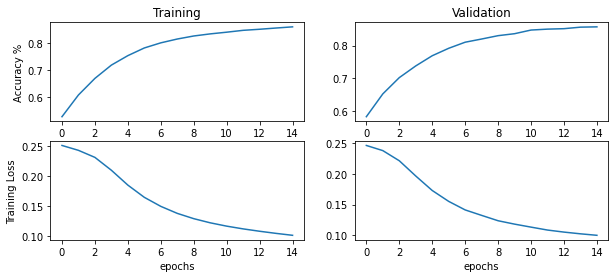

In [58]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history21.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history21.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history21.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history21.history['val_loss'])
plt.xlabel('epochs')

In [59]:
results = PrettyTable()
results.add_column("Fold", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
results.add_column("Accuracy", VALIDATION_ACCURACY21)
results.add_column("AUC", VALIDATION_AUC21)
print(results)

+------+--------------------+--------------------+
| Fold |      Accuracy      |        AUC         |
+------+--------------------+--------------------+
|  1   | 0.8559556603431702 | 0.9385308027267456 |
|  2   | 0.8527238965034485 | 0.9329344630241394 |
|  3   | 0.8227146863937378 | 0.9160408973693848 |
|  4   | 0.8314865827560425 | 0.9177548289299011 |
|  5   | 0.8504155278205872 | 0.9346563816070557 |
|  6   | 0.8490304946899414 | 0.9332733154296875 |
|  7   | 0.8462603688240051 | 0.9301101565361023 |
|  8   | 0.8490304946899414 | 0.9341230392456055 |
|  9   | 0.8715935349464417 | 0.9421837329864502 |
|  10  | 0.8568129539489746 | 0.9396765828132629 |
+------+--------------------+--------------------+


In [60]:
idx = VALIDATION_ACCURACY21.index(max(VALIDATION_ACCURACY21))
max_fold21 = idx + 1
print("Best Fold:", max_fold21)

Best Fold: 9


In [61]:
model21.load_weights("\saved_models2_1/model_"+str(max_fold21)+".h5")
    
# get crossed columns
X_test_crossed = X_test[cross_col_df_names1].to_numpy()

# save categorical features
X_test_cat = X_test[categorical_headers].to_numpy() 

# and save off the numeric features
X_test_num = X_test[numeric_headers].to_numpy()

model21.evaluate([X_test_crossed,X_test_cat,X_test_num], y_test)

211/211 [==============================] - 0s 954us/step - loss: 0.1442 - accuracy: 0.7943 - auc: 0.8779


[0.14418970048427582, 0.7943009734153748, 0.8778643608093262]

In [96]:
yhat_proba = model21.predict([X_test_crossed, X_test_cat, X_test_num])
yhat21 = np.round(yhat_proba)

211/211 [==============================] - 0s 801us/step


### Wide and Deep Network 2 - Even More Layers

In [62]:
kfold = 1
#kf = KFold(n_splits = 10, shuffle = True, random_state = 24)

VALIDATION_ACCURACY22 = []
VALIDATION_AUC22 = []

for train_index, val_index in kf.split(X_train):
    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]
    y_train1 = y_train[[train_index]].reshape(-1,1)
    y_val = y_train[[val_index]].reshape(-1,1)
    
    # get crossed columns
    X_train_crossed = training_data[cross_col_df_names2].to_numpy()
    X_test_crossed = validation_data[cross_col_df_names2].to_numpy()

    # save categorical features
    X_train_cat = training_data[categorical_headers].to_numpy() 
    X_test_cat = validation_data[categorical_headers].to_numpy() 

    # and save off the numeric features
    X_train_num =  training_data[numeric_headers].to_numpy()
    X_test_num = validation_data[numeric_headers].to_numpy()
    
    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names2):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        crossed_outputs.append(x)
    

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep4')(deep_branch) 
    deep_branch = Dense(units=10,activation='relu', name='deep5')(deep_branch) # added this!
    
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch], name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)
    
    model22 = Model(inputs=[input_crossed,input_cat,input_num], outputs=final_branch)
    
    model22.compile(loss = "mean_squared_error",
                 optimizer = 'sgd', metrics = ['accuracy', 'AUC'])
    
    save_dir = '\saved_models2_2/'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(kfold), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    history22 = model22.fit([X_train_crossed,X_train_cat,X_train_num], y_train1, epochs=15, batch_size=32, verbose=1,
                        callbacks = [callbacks_list],
                        validation_data = ([X_test_crossed,X_test_cat,X_test_num], y_val))
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model22.load_weights("\saved_models2_2/model_"+str(kfold)+".h5")

    results = model22.evaluate([X_test_crossed,X_test_cat,X_test_num], y_val)
    results = dict(zip(model22.metrics_names,results))

    VALIDATION_ACCURACY22.append(results['accuracy'])
    VALIDATION_AUC22.append(results['auc'])
    
    tf.keras.backend.clear_session()
    
    kfold += 1

Epoch 1/15
586/610 [===========================>..] - ETA: 0s - loss: 0.2492 - accuracy: 0.5304 - auc: 0.5018
Epoch 1: val_accuracy improved from -inf to 0.54524, saving model to \saved_models2_2/model_1.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.2493 - accuracy: 0.5291 - auc: 0.5032 - val_loss: 0.2475 - val_accuracy: 0.5452 - val_auc: 0.5620
Epoch 2/15
598/610 [============================>.] - ETA: 0s - loss: 0.2476 - accuracy: 0.5366 - auc: 0.5776
Epoch 2: val_accuracy improved from 0.54524 to 0.55078, saving model to \saved_models2_2/model_1.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2475 - accuracy: 0.5368 - auc: 0.5783 - val_loss: 0.2459 - val_accuracy: 0.5508 - val_auc: 0.6258
Epoch 3/15
581/610 [===========================>..] - ETA: 0s - loss: 0.2461 - accuracy: 0.5372 - auc: 0.6264
Epoch 3: val_accuracy improved from 0.55078 to 0.55633, saving model to \saved_models2_2/model_1.h5
610/610 [==============================] - 1s 1

Epoch 8/15
606/610 [============================>.] - ETA: 0s - loss: 0.1255 - accuracy: 0.8237 - auc: 0.9066
Epoch 8: val_accuracy improved from 0.82595 to 0.82872, saving model to \saved_models2_2/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1255 - accuracy: 0.8237 - auc: 0.9066 - val_loss: 0.1209 - val_accuracy: 0.8287 - val_auc: 0.9127
Epoch 9/15
610/610 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.8288 - auc: 0.9150
Epoch 9: val_accuracy improved from 0.82872 to 0.83518, saving model to \saved_models2_2/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1194 - accuracy: 0.8288 - auc: 0.9150 - val_loss: 0.1157 - val_accuracy: 0.8352 - val_auc: 0.9189
Epoch 10/15
605/610 [============================>.] - ETA: 0s - loss: 0.1145 - accuracy: 0.8366 - auc: 0.9210
Epoch 10: val_accuracy improved from 0.83518 to 0.84395, saving model to \saved_models2_2/model_2.h5
610/610 [==============================] -

Epoch 15/15
602/610 [============================>.] - ETA: 0s - loss: 0.1062 - accuracy: 0.8485 - auc: 0.9310
Epoch 15: val_accuracy improved from 0.82225 to 0.82318, saving model to \saved_models2_2/model_3.h5
68/68 [==============================] - 0s 1ms/step - loss: 0.1188 - accuracy: 0.8232 - auc: 0.9169
Epoch 1/15
597/610 [============================>.] - ETA: 0s - loss: 0.2494 - accuracy: 0.5320 - auc: 0.5451
Epoch 1: val_accuracy improved from -inf to 0.56140, saving model to \saved_models2_2/model_4.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.2494 - accuracy: 0.5331 - auc: 0.5462 - val_loss: 0.2472 - val_accuracy: 0.5614 - val_auc: 0.5948
Epoch 2/15
607/610 [============================>.] - ETA: 0s - loss: 0.2446 - accuracy: 0.5948 - auc: 0.6423
Epoch 2: val_accuracy improved from 0.56140 to 0.60849, saving model to \saved_models2_2/model_4.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2446 - accuracy: 0.5949 - auc: 0.6422 - va

610/610 [==============================] - 1s 1ms/step - loss: 0.2161 - accuracy: 0.7263 - auc: 0.7905 - val_loss: 0.2006 - val_accuracy: 0.7461 - val_auc: 0.8139
Epoch 7/15
566/610 [==========================>...] - ETA: 0s - loss: 0.1886 - accuracy: 0.7566 - auc: 0.8241
Epoch 7: val_accuracy improved from 0.74608 to 0.76962, saving model to \saved_models2_2/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1878 - accuracy: 0.7578 - auc: 0.8244 - val_loss: 0.1761 - val_accuracy: 0.7696 - val_auc: 0.8397
Epoch 8/15
564/610 [==========================>...] - ETA: 0s - loss: 0.1674 - accuracy: 0.7808 - auc: 0.8490
Epoch 8: val_accuracy improved from 0.76962 to 0.78670, saving model to \saved_models2_2/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1664 - accuracy: 0.7827 - auc: 0.8509 - val_loss: 0.1582 - val_accuracy: 0.7867 - val_auc: 0.8620
Epoch 9/15
587/610 [===========================>..] - ETA: 0s - loss: 0.1509 - accuracy: 0.

589/610 [===========================>..] - ETA: 0s - loss: 0.1096 - accuracy: 0.8480 - auc: 0.9298
Epoch 13: val_accuracy improved from 0.83703 to 0.84072, saving model to \saved_models2_2/model_6.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1097 - accuracy: 0.8481 - auc: 0.9296 - val_loss: 0.1135 - val_accuracy: 0.8407 - val_auc: 0.9249
Epoch 14/15
608/610 [============================>.] - ETA: 0s - loss: 0.1065 - accuracy: 0.8529 - auc: 0.9335
Epoch 14: val_accuracy improved from 0.84072 to 0.84257, saving model to \saved_models2_2/model_6.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1065 - accuracy: 0.8529 - auc: 0.9334 - val_loss: 0.1117 - val_accuracy: 0.8426 - val_auc: 0.9277
Epoch 15/15
583/610 [===========================>..] - ETA: 0s - loss: 0.1035 - accuracy: 0.8561 - auc: 0.9367
Epoch 15: val_accuracy improved from 0.84257 to 0.84441, saving model to \saved_models2_2/model_6.h5
68/68 [==============================] - 0s 979us/

610/610 [==============================] - 1s 1ms/step - loss: 0.2236 - accuracy: 0.6803 - auc: 0.7367 - val_loss: 0.2095 - val_accuracy: 0.7082 - val_auc: 0.7685
Epoch 5/15
597/610 [============================>.] - ETA: 0s - loss: 0.2007 - accuracy: 0.7116 - auc: 0.7775
Epoch 5: val_accuracy improved from 0.70822 to 0.73638, saving model to \saved_models2_2/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2004 - accuracy: 0.7121 - auc: 0.7784 - val_loss: 0.1856 - val_accuracy: 0.7364 - val_auc: 0.8054
Epoch 6/15
604/610 [============================>.] - ETA: 0s - loss: 0.1766 - accuracy: 0.7489 - auc: 0.8222
Epoch 6: val_accuracy improved from 0.73638 to 0.76731, saving model to \saved_models2_2/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1765 - accuracy: 0.7492 - auc: 0.8226 - val_loss: 0.1645 - val_accuracy: 0.7673 - val_auc: 0.8440
Epoch 7/15
564/610 [==========================>...] - ETA: 0s - loss: 0.1566 - accuracy: 0.

610/610 [==============================] - 1s 1ms/step - loss: 0.1119 - accuracy: 0.8383 - auc: 0.9236 - val_loss: 0.1133 - val_accuracy: 0.8300 - val_auc: 0.9213
Epoch 12/15
567/610 [==========================>...] - ETA: 0s - loss: 0.1091 - accuracy: 0.8431 - auc: 0.9271
Epoch 12: val_accuracy improved from 0.83048 to 0.83510, saving model to \saved_models2_2/model_9.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1095 - accuracy: 0.8427 - auc: 0.9264 - val_loss: 0.1114 - val_accuracy: 0.8351 - val_auc: 0.9251
Epoch 13/15
583/610 [===========================>..] - ETA: 0s - loss: 0.1077 - accuracy: 0.8447 - auc: 0.9288
Epoch 13: val_accuracy improved from 0.83510 to 0.83695, saving model to \saved_models2_2/model_9.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1075 - accuracy: 0.8449 - auc: 0.9291 - val_loss: 0.1090 - val_accuracy: 0.8370 - val_auc: 0.9275
Epoch 14/15
569/610 [==========================>...] - ETA: 0s - loss: 0.1053 - accurac

Text(0.5, 0, 'epochs')

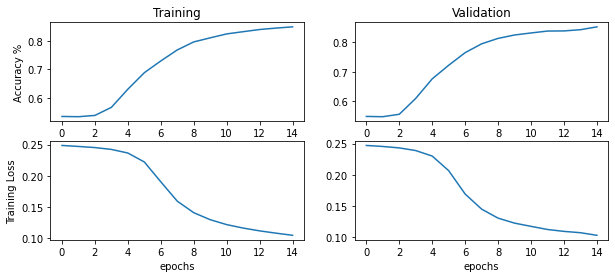

In [63]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history22.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history22.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history22.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history22.history['val_loss'])
plt.xlabel('epochs')

In [64]:
results = PrettyTable()
results.add_column("Fold", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
results.add_column("Accuracy", VALIDATION_ACCURACY22)
results.add_column("AUC", VALIDATION_AUC22)
print(results)

+------+--------------------+--------------------+
| Fold |      Accuracy      |        AUC         |
+------+--------------------+--------------------+
|  1   | 0.8079409003257751 | 0.8942816257476807 |
|  2   | 0.8684210777282715 | 0.9464473128318787 |
|  3   | 0.823176383972168  | 0.916935384273529  |
|  4   | 0.8264081478118896 | 0.9227609038352966 |
|  5   | 0.8504155278205872 | 0.9348542094230652 |
|  6   | 0.8444136381149292 | 0.9305239915847778 |
|  7   | 0.8578023910522461 | 0.9417527914047241 |
|  8   | 0.8545706272125244 | 0.9422078132629395 |
|  9   | 0.8387990593910217 | 0.9323523640632629 |
|  10  | 0.8531177639961243 | 0.9365938305854797 |
+------+--------------------+--------------------+


In [65]:
idx = VALIDATION_ACCURACY22.index(max(VALIDATION_ACCURACY22))
max_fold22 = idx + 1
print("Best Fold:", max_fold22)

Best Fold: 2


In [66]:
model22.load_weights("\saved_models2_2/model_"+str(max_fold22)+".h5")
    
# get crossed columns
X_test_crossed = X_test[cross_col_df_names1].to_numpy()

# save categorical features
X_test_cat = X_test[categorical_headers].to_numpy() 

# and save off the numeric features
X_test_num = X_test[numeric_headers].to_numpy()

model22.evaluate([X_test_crossed,X_test_cat,X_test_num], y_test)

211/211 [==============================] - 0s 967us/step - loss: 0.1367 - accuracy: 0.8031 - auc: 0.8910


[0.13673126697540283, 0.8030573129653931, 0.8909838199615479]

In [95]:
yhat_proba = model22.predict([X_test_crossed, X_test_cat, X_test_num])
yhat22 = np.round(yhat_proba)

211/211 [==============================] - 0s 811us/step


### Compare Generalization Performance for W/D 2 - McNemar's Test

In [144]:
wd2 = pd.DataFrame()
wd2['Deep'] = list(chain.from_iterable(yhat2))
wd2['Deeper'] = list(chain.from_iterable(yhat21))
wd2['Deepest'] = list(chain.from_iterable(yhat22))
wd2['Truth'] = list(chain.from_iterable(y_test))

In [145]:
conditions = [
    (wd2['Deep'] == wd2['Truth']) & (wd2['Deeper'] == wd2['Truth']), # both models are right (A)
    (wd2['Deep'] == wd2['Truth']) & (wd2['Deeper'] != wd2['Truth']), # model 1 is right, model 2 is wrong (B)
    (wd2['Deep'] != wd2['Truth']) & (wd2['Deeper'] == wd2['Truth']), # model 1 is wrong, model 2 is right (C)
    (wd2['Deep'] != wd2['Truth']) & (wd2['Deeper'] != wd2['Truth'])] # both models are wrong (D)
choices = ['A', 'B', 'C', 'D'] 

wd2['Matrix1v2'] = np.select(conditions, choices, default = '0')
wd2.Matrix1v2.value_counts()

A    4968
D     958
B     428
C     384
Name: Matrix1v2, dtype: int64

In [146]:
B = sum(wd2['Matrix1v2'] == 'B')
C = sum(wd2['Matrix1v2'] == 'C')
chisq = (abs(B - C) - 1)**2 / (B + C)
print(round(chisq, 3))

2.277


Since 2.277 < 3.841 ($\alpha$ = 0.05 significance level), we fail to reject the null hypothesis that the models are the same.

In [147]:
conditions = [
    (wd2['Deep'] == wd2['Truth']) & (wd2['Deepest'] == wd2['Truth']), # both models are right (A)
    (wd2['Deep'] == wd2['Truth']) & (wd2['Deepest'] != wd2['Truth']), # model 1 is right, model 2 is wrong (B)
    (wd2['Deep'] != wd2['Truth']) & (wd2['Deepest'] == wd2['Truth']), # model 1 is wrong, model 2 is right (C)
    (wd2['Deep'] != wd2['Truth']) & (wd2['Deepest'] != wd2['Truth'])] # both models are wrong (D)
choices = ['A', 'B', 'C', 'D'] 

wd2['Matrix1v3'] = np.select(conditions, choices, default = '0')
wd2.Matrix1v3.value_counts()

A    5002
D     933
C     409
B     394
Name: Matrix1v3, dtype: int64

In [148]:
B = sum(wd2['Matrix1v3'] == 'B')
C = sum(wd2['Matrix1v3'] == 'C')
chisq = (abs(B - C) - 1)**2 / (B + C)
print(round(chisq, 3))

0.244


Since 0.244 < 3.841 ($\alpha$ = 0.05 significance level), we fail to reject the null hypothesis that the models are the same.

### Wide and Deep Network 3 - More Layers

In [67]:
kfold = 1
#kf = KFold(n_splits = 10, shuffle = True, random_state = 24)

VALIDATION_ACCURACY31 = []
VALIDATION_AUC31 = []

for train_index, val_index in kf.split(X_train):
    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]
    y_train1 = y_train[[train_index]].reshape(-1,1)
    y_val = y_train[[val_index]].reshape(-1,1)
    
    # get crossed columns
    X_train_crossed = training_data[cross_col_df_names3].to_numpy()
    X_test_crossed = validation_data[cross_col_df_names3].to_numpy()

    # save categorical features
    X_train_cat = training_data[categorical_headers].to_numpy() 
    X_test_cat = validation_data[categorical_headers].to_numpy() 

    # and save off the numeric features
    X_train_num =  training_data[numeric_headers].to_numpy()
    X_test_num = validation_data[numeric_headers].to_numpy()
    
    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names3):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        crossed_outputs.append(x)
    

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep4')(deep_branch) # added this
    
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch], name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)
    
    model31 = Model(inputs=[input_crossed,input_cat,input_num], outputs=final_branch)
    
    model31.compile(loss = "mean_squared_error",
                 optimizer = 'sgd', metrics = ['accuracy', 'AUC'])
    
    save_dir = '\saved_models3_1/'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(kfold), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    history31 = model31.fit([X_train_crossed,X_train_cat,X_train_num], y_train1, epochs=15, batch_size=32, verbose=1,
                        callbacks = [callbacks_list],
                        validation_data = ([X_test_crossed,X_test_cat,X_test_num], y_val))
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model31.load_weights("\saved_models3_1/model_"+str(kfold)+".h5")

    results = model31.evaluate([X_test_crossed,X_test_cat,X_test_num], y_val)
    results = dict(zip(model31.metrics_names,results))

    VALIDATION_ACCURACY31.append(results['accuracy'])
    VALIDATION_AUC31.append(results['auc'])
    
    tf.keras.backend.clear_session()
    
    kfold += 1

Epoch 1/15
597/610 [============================>.] - ETA: 0s - loss: 0.2458 - accuracy: 0.5707 - auc: 0.6008
Epoch 1: val_accuracy improved from -inf to 0.62465, saving model to \saved_models3_1/model_1.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.2457 - accuracy: 0.5726 - auc: 0.6038 - val_loss: 0.2394 - val_accuracy: 0.6247 - val_auc: 0.6922
Epoch 2/15
577/610 [===========================>..] - ETA: 0s - loss: 0.2334 - accuracy: 0.6441 - auc: 0.7326
Epoch 2: val_accuracy improved from 0.62465 to 0.68560, saving model to \saved_models3_1/model_1.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2330 - accuracy: 0.6461 - auc: 0.7327 - val_loss: 0.2232 - val_accuracy: 0.6856 - val_auc: 0.7720
Epoch 3/15
578/610 [===========================>..] - ETA: 0s - loss: 0.2132 - accuracy: 0.7028 - auc: 0.7842
Epoch 3: val_accuracy improved from 0.68560 to 0.73084, saving model to \saved_models3_1/model_1.h5
610/610 [==============================] - 1s 1

567/610 [==========================>...] - ETA: 0s - loss: 0.1223 - accuracy: 0.8236 - auc: 0.9088
Epoch 8: val_accuracy improved from 0.82502 to 0.83149, saving model to \saved_models3_1/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1223 - accuracy: 0.8236 - auc: 0.9086 - val_loss: 0.1164 - val_accuracy: 0.8315 - val_auc: 0.9203
Epoch 9/15
594/610 [============================>.] - ETA: 0s - loss: 0.1180 - accuracy: 0.8298 - auc: 0.9145
Epoch 9: val_accuracy improved from 0.83149 to 0.83934, saving model to \saved_models3_1/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1178 - accuracy: 0.8299 - auc: 0.9149 - val_loss: 0.1107 - val_accuracy: 0.8393 - val_auc: 0.9260
Epoch 10/15
574/610 [===========================>..] - ETA: 0s - loss: 0.1144 - accuracy: 0.8345 - auc: 0.9195
Epoch 10: val_accuracy did not improve from 0.83934
610/610 [==============================] - 1s 1ms/step - loss: 0.1144 - accuracy: 0.8348 - auc: 0.9196

608/610 [============================>.] - ETA: 0s - loss: 0.1005 - accuracy: 0.8587 - auc: 0.9375
Epoch 15: val_accuracy improved from 0.83795 to 0.84164, saving model to \saved_models3_1/model_3.h5
68/68 [==============================] - 0s 1ms/step - loss: 0.1106 - accuracy: 0.8416 - auc: 0.9253
Epoch 1/15
572/610 [===========================>..] - ETA: 0s - loss: 0.2456 - accuracy: 0.5904 - auc: 0.6427
Epoch 1: val_accuracy improved from -inf to 0.59695, saving model to \saved_models3_1/model_4.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2453 - accuracy: 0.5921 - auc: 0.6482 - val_loss: 0.2426 - val_accuracy: 0.5970 - val_auc: 0.7276
Epoch 2/15
596/610 [============================>.] - ETA: 0s - loss: 0.2363 - accuracy: 0.6342 - auc: 0.7856
Epoch 2: val_accuracy improved from 0.59695 to 0.65420, saving model to \saved_models3_1/model_4.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2362 - accuracy: 0.6356 - auc: 0.7861 - val_loss: 0.23

Epoch 7/15
566/610 [==========================>...] - ETA: 0s - loss: 0.1381 - accuracy: 0.8292 - auc: 0.8946
Epoch 7: val_accuracy improved from 0.82271 to 0.83472, saving model to \saved_models3_1/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1375 - accuracy: 0.8302 - auc: 0.8952 - val_loss: 0.1327 - val_accuracy: 0.8347 - val_auc: 0.8948
Epoch 8/15
568/610 [==========================>...] - ETA: 0s - loss: 0.1272 - accuracy: 0.8374 - auc: 0.9042
Epoch 8: val_accuracy improved from 0.83472 to 0.83841, saving model to \saved_models3_1/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1271 - accuracy: 0.8374 - auc: 0.9040 - val_loss: 0.1245 - val_accuracy: 0.8384 - val_auc: 0.9030
Epoch 9/15
603/610 [============================>.] - ETA: 0s - loss: 0.1205 - accuracy: 0.8420 - auc: 0.9104
Epoch 9: val_accuracy improved from 0.83841 to 0.83934, saving model to \saved_models3_1/model_5.h5
610/610 [==============================] - 1

Epoch 14/15
574/610 [===========================>..] - ETA: 0s - loss: 0.1097 - accuracy: 0.8477 - auc: 0.9256
Epoch 14: val_accuracy improved from 0.84626 to 0.84672, saving model to \saved_models3_1/model_6.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1090 - accuracy: 0.8487 - auc: 0.9266 - val_loss: 0.1126 - val_accuracy: 0.8467 - val_auc: 0.9214
Epoch 15/15
578/610 [===========================>..] - ETA: 0s - loss: 0.1083 - accuracy: 0.8481 - auc: 0.9277
Epoch 15: val_accuracy did not improve from 0.84672
68/68 [==============================] - 0s 985us/step - loss: 0.1126 - accuracy: 0.8467 - auc: 0.9214
Epoch 1/15
597/610 [============================>.] - ETA: 0s - loss: 0.2491 - accuracy: 0.5204 - auc: 0.5147
Epoch 1: val_accuracy improved from -inf to 0.55725, saving model to \saved_models3_1/model_7.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.2490 - accuracy: 0.5206 - auc: 0.5166 - val_loss: 0.2465 - val_accuracy: 0.5572 - val_a

Epoch 6/15
575/610 [===========================>..] - ETA: 0s - loss: 0.1541 - accuracy: 0.8050 - auc: 0.8758
Epoch 6: val_accuracy improved from 0.79548 to 0.81025, saving model to \saved_models3_1/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1539 - accuracy: 0.8052 - auc: 0.8758 - val_loss: 0.1452 - val_accuracy: 0.8102 - val_auc: 0.8830
Epoch 7/15
577/610 [===========================>..] - ETA: 0s - loss: 0.1383 - accuracy: 0.8207 - auc: 0.8908
Epoch 7: val_accuracy improved from 0.81025 to 0.82410, saving model to \saved_models3_1/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1382 - accuracy: 0.8211 - auc: 0.8904 - val_loss: 0.1322 - val_accuracy: 0.8241 - val_auc: 0.8957
Epoch 8/15
604/610 [============================>.] - ETA: 0s - loss: 0.1283 - accuracy: 0.8312 - auc: 0.9003
Epoch 8: val_accuracy improved from 0.82410 to 0.83518, saving model to \saved_models3_1/model_8.h5
610/610 [==============================] - 1

Epoch 13/15
568/610 [==========================>...] - ETA: 0s - loss: 0.1114 - accuracy: 0.8490 - auc: 0.9243
Epoch 13: val_accuracy improved from 0.84942 to 0.85219, saving model to \saved_models3_1/model_9.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1111 - accuracy: 0.8495 - auc: 0.9246 - val_loss: 0.1101 - val_accuracy: 0.8522 - val_auc: 0.9262
Epoch 14/15
568/610 [==========================>...] - ETA: 0s - loss: 0.1092 - accuracy: 0.8503 - auc: 0.9270
Epoch 14: val_accuracy improved from 0.85219 to 0.85589, saving model to \saved_models3_1/model_9.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1096 - accuracy: 0.8497 - auc: 0.9263 - val_loss: 0.1090 - val_accuracy: 0.8559 - val_auc: 0.9270
Epoch 15/15
593/610 [============================>.] - ETA: 0s - loss: 0.1082 - accuracy: 0.8520 - auc: 0.9283
Epoch 15: val_accuracy improved from 0.85589 to 0.85635, saving model to \saved_models3_1/model_9.h5
68/68 [==============================]

Text(0.5, 0, 'epochs')

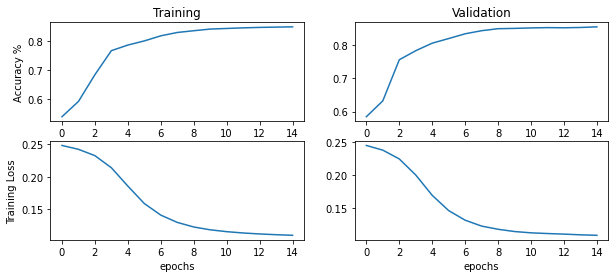

In [68]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history31.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history31.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history31.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history31.history['val_loss'])
plt.xlabel('epochs')

In [69]:
results = PrettyTable()
results.add_column("Fold", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
results.add_column("Accuracy", VALIDATION_ACCURACY31)
results.add_column("AUC", VALIDATION_AUC31)
print(results)

+------+--------------------+--------------------+
| Fold |      Accuracy      |        AUC         |
+------+--------------------+--------------------+
|  1   | 0.8430286049842834 | 0.9252426624298096 |
|  2   | 0.8531855940818787 | 0.9371157884597778 |
|  3   | 0.8416435718536377 | 0.925330400466919  |
|  4   | 0.8208679556846619 | 0.9110730290412903 |
|  5   | 0.8527238965034485 | 0.9248325228691101 |
|  6   | 0.8467220664024353 | 0.9214075207710266 |
|  7   | 0.849953830242157  | 0.8898619413375854 |
|  8   | 0.8568790555000305 | 0.9254499673843384 |
|  9   | 0.8563510179519653 | 0.9278494119644165 |
|  10  | 0.8545034527778625 | 0.9252508878707886 |
+------+--------------------+--------------------+


In [70]:
idx = VALIDATION_ACCURACY31.index(max(VALIDATION_ACCURACY31))
max_fold31 = idx + 1
print("Best Fold:", max_fold31)

Best Fold: 8


In [71]:
model31.load_weights("\saved_models3_1/model_"+str(max_fold31)+".h5")
    
# get crossed columns
X_test_crossed = X_test[cross_col_df_names1].to_numpy()

# save categorical features
X_test_cat = X_test[categorical_headers].to_numpy() 

# and save off the numeric features
X_test_num = X_test[numeric_headers].to_numpy()

model31.evaluate([X_test_crossed,X_test_cat,X_test_num], y_test)

211/211 [==============================] - 0s 948us/step - loss: 0.1407 - accuracy: 0.8041 - auc: 0.8802


[0.14068499207496643, 0.8040961623191833, 0.8801827430725098]

In [94]:
yhat_proba = model31.predict([X_test_crossed, X_test_cat, X_test_num])
yhat31 = np.round(yhat_proba)

211/211 [==============================] - 0s 792us/step


### Wide and Deep Network 3 - Even More Layers

In [72]:
kfold = 1
#kf = KFold(n_splits = 10, shuffle = True, random_state = 24)

VALIDATION_ACCURACY32 = []
VALIDATION_AUC32 = []

for train_index, val_index in kf.split(X_train):
    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]
    y_train1 = y_train[[train_index]].reshape(-1,1)
    y_val = y_train[[val_index]].reshape(-1,1)
    
    # get crossed columns
    X_train_crossed = training_data[cross_col_df_names3].to_numpy()
    X_test_crossed = validation_data[cross_col_df_names3].to_numpy()

    # save categorical features
    X_train_cat = training_data[categorical_headers].to_numpy() 
    X_test_cat = validation_data[categorical_headers].to_numpy() 

    # and save off the numeric features
    X_train_num =  training_data[numeric_headers].to_numpy()
    X_test_num = validation_data[numeric_headers].to_numpy()
    
    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names3):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        crossed_outputs.append(x)
    

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep4')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep5')(deep_branch) # added this
    
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch], name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)
    
    model32 = Model(inputs=[input_crossed,input_cat,input_num], outputs=final_branch)
    
    model32.compile(loss = "mean_squared_error",
                 optimizer = 'sgd', metrics = ['accuracy', 'AUC'])
    
    save_dir = '\saved_models3_2/'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(kfold), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    history32 = model32.fit([X_train_crossed,X_train_cat,X_train_num], y_train1, epochs=15, batch_size=32, verbose=1,
                        callbacks = [callbacks_list],
                        validation_data = ([X_test_crossed,X_test_cat,X_test_num], y_val))
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model32.load_weights("\saved_models3_2/model_"+str(kfold)+".h5")

    results = model32.evaluate([X_test_crossed,X_test_cat,X_test_num], y_val)
    results = dict(zip(model32.metrics_names,results))

    VALIDATION_ACCURACY32.append(results['accuracy'])
    VALIDATION_AUC32.append(results['auc'])
    
    tf.keras.backend.clear_session()
    
    kfold += 1

Epoch 1/15
594/610 [============================>.] - ETA: 0s - loss: 0.2470 - accuracy: 0.5754 - auc: 0.6172
Epoch 1: val_accuracy improved from -inf to 0.59049, saving model to \saved_models3_2/model_1.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.2469 - accuracy: 0.5756 - auc: 0.6187 - val_loss: 0.2430 - val_accuracy: 0.5905 - val_auc: 0.7519
Epoch 2/15
590/610 [============================>.] - ETA: 0s - loss: 0.2402 - accuracy: 0.5891 - auc: 0.7963
Epoch 2: val_accuracy improved from 0.59049 to 0.64820, saving model to \saved_models3_2/model_1.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2401 - accuracy: 0.5899 - auc: 0.7974 - val_loss: 0.2348 - val_accuracy: 0.6482 - val_auc: 0.8430
Epoch 3/15
572/610 [===========================>..] - ETA: 0s - loss: 0.2302 - accuracy: 0.6954 - auc: 0.8526
Epoch 3: val_accuracy improved from 0.64820 to 0.76408, saving model to \saved_models3_2/model_1.h5
610/610 [==============================] - 1s 1

610/610 [==============================] - 1s 1ms/step - loss: 0.1421 - accuracy: 0.8233 - auc: 0.8898 - val_loss: 0.1344 - val_accuracy: 0.8324 - val_auc: 0.9009
Epoch 9/15
577/610 [===========================>..] - ETA: 0s - loss: 0.1306 - accuracy: 0.8349 - auc: 0.9014
Epoch 9: val_accuracy improved from 0.83241 to 0.83795, saving model to \saved_models3_2/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1308 - accuracy: 0.8340 - auc: 0.9008 - val_loss: 0.1254 - val_accuracy: 0.8380 - val_auc: 0.9092
Epoch 10/15
607/610 [============================>.] - ETA: 0s - loss: 0.1235 - accuracy: 0.8401 - auc: 0.9081
Epoch 10: val_accuracy improved from 0.83795 to 0.84580, saving model to \saved_models3_2/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1235 - accuracy: 0.8400 - auc: 0.9082 - val_loss: 0.1194 - val_accuracy: 0.8458 - val_auc: 0.9142
Epoch 11/15
576/610 [===========================>..] - ETA: 0s - loss: 0.1184 - accuracy:

68/68 [==============================] - 0s 985us/step - loss: 0.1317 - accuracy: 0.8384 - auc: 0.8826
Epoch 1/15
567/610 [==========================>...] - ETA: 0s - loss: 0.2437 - accuracy: 0.6213 - auc: 0.7158
Epoch 1: val_accuracy improved from -inf to 0.59926, saving model to \saved_models3_2/model_4.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.2433 - accuracy: 0.6196 - auc: 0.7212 - val_loss: 0.2396 - val_accuracy: 0.5993 - val_auc: 0.8164
Epoch 2/15
607/610 [============================>.] - ETA: 0s - loss: 0.2328 - accuracy: 0.6552 - auc: 0.8543
Epoch 2: val_accuracy improved from 0.59926 to 0.68236, saving model to \saved_models3_2/model_4.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2328 - accuracy: 0.6552 - auc: 0.8545 - val_loss: 0.2280 - val_accuracy: 0.6824 - val_auc: 0.8525
Epoch 3/15
604/610 [============================>.] - ETA: 0s - loss: 0.2168 - accuracy: 0.7575 - auc: 0.8727
Epoch 3: val_accuracy improved from 0.68236 

610/610 [==============================] - 1s 1ms/step - loss: 0.1377 - accuracy: 0.8400 - auc: 0.8874 - val_loss: 0.1319 - val_accuracy: 0.8467 - val_auc: 0.8903
Epoch 9/15
600/610 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.8427 - auc: 0.8912
Epoch 9: val_accuracy improved from 0.84672 to 0.84903, saving model to \saved_models3_2/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1302 - accuracy: 0.8432 - auc: 0.8917 - val_loss: 0.1258 - val_accuracy: 0.8490 - val_auc: 0.8945
Epoch 10/15
603/610 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.8447 - auc: 0.8953
Epoch 10: val_accuracy improved from 0.84903 to 0.84995, saving model to \saved_models3_2/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1256 - accuracy: 0.8445 - auc: 0.8954 - val_loss: 0.1221 - val_accuracy: 0.8500 - val_auc: 0.8984
Epoch 11/15
597/610 [============================>.] - ETA: 0s - loss: 0.1226 - accuracy:

68/68 [==============================] - 0s 1ms/step - loss: 0.1095 - accuracy: 0.8490 - auc: 0.9246
Epoch 1/15
588/610 [===========================>..] - ETA: 0s - loss: 0.2465 - accuracy: 0.5480 - auc: 0.6092
Epoch 1: val_accuracy improved from -inf to 0.57618, saving model to \saved_models3_2/model_7.h5
610/610 [==============================] - 2s 2ms/step - loss: 0.2464 - accuracy: 0.5480 - auc: 0.6136 - val_loss: 0.2418 - val_accuracy: 0.5762 - val_auc: 0.7484
Epoch 2/15
583/610 [===========================>..] - ETA: 0s - loss: 0.2377 - accuracy: 0.6209 - auc: 0.8204
Epoch 2: val_accuracy improved from 0.57618 to 0.67267, saving model to \saved_models3_2/model_7.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2375 - accuracy: 0.6234 - auc: 0.8215 - val_loss: 0.2313 - val_accuracy: 0.6727 - val_auc: 0.8560
Epoch 3/15
600/610 [============================>.] - ETA: 0s - loss: 0.2244 - accuracy: 0.7489 - auc: 0.8664
Epoch 3: val_accuracy improved from 0.67267 to

Epoch 9/15
605/610 [============================>.] - ETA: 0s - loss: 0.1159 - accuracy: 0.8346 - auc: 0.9188
Epoch 9: val_accuracy improved from 0.83610 to 0.84580, saving model to \saved_models3_2/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1159 - accuracy: 0.8346 - auc: 0.9188 - val_loss: 0.1092 - val_accuracy: 0.8458 - val_auc: 0.9287
Epoch 10/15
589/610 [===========================>..] - ETA: 0s - loss: 0.1122 - accuracy: 0.8405 - auc: 0.9235
Epoch 10: val_accuracy improved from 0.84580 to 0.85134, saving model to \saved_models3_2/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1124 - accuracy: 0.8399 - auc: 0.9232 - val_loss: 0.1062 - val_accuracy: 0.8513 - val_auc: 0.9330
Epoch 11/15
596/610 [============================>.] - ETA: 0s - loss: 0.1097 - accuracy: 0.8441 - auc: 0.9268
Epoch 11: val_accuracy improved from 0.85134 to 0.85319, saving model to \saved_models3_2/model_8.h5
610/610 [==============================]

68/68 [==============================] - 0s 1ms/step - loss: 0.1114 - accuracy: 0.8540 - auc: 0.9185
Epoch 1/15
606/610 [============================>.] - ETA: 0s - loss: 0.2499 - accuracy: 0.5259 - auc: 0.4752
Epoch 1: val_accuracy improved from -inf to 0.53995, saving model to \saved_models3_2/model_10.h5
610/610 [==============================] - 1s 2ms/step - loss: 0.2499 - accuracy: 0.5259 - auc: 0.4753 - val_loss: 0.2480 - val_accuracy: 0.5400 - val_auc: 0.5287
Epoch 2/15
598/610 [============================>.] - ETA: 0s - loss: 0.2471 - accuracy: 0.5388 - auc: 0.5891
Epoch 2: val_accuracy improved from 0.53995 to 0.54688, saving model to \saved_models3_2/model_10.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2470 - accuracy: 0.5392 - auc: 0.5908 - val_loss: 0.2449 - val_accuracy: 0.5469 - val_auc: 0.6480
Epoch 3/15
584/610 [===========================>..] - ETA: 0s - loss: 0.2435 - accuracy: 0.5469 - auc: 0.7108
Epoch 3: val_accuracy improved from 0.54688 

Text(0.5, 0, 'epochs')

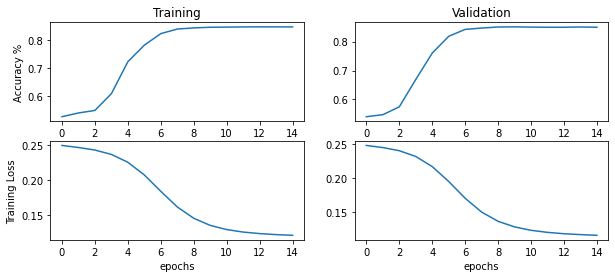

In [73]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history32.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history32.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history32.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history32.history['val_loss'])
plt.xlabel('epochs')

In [74]:
results = PrettyTable()
results.add_column("Fold", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
results.add_column("Accuracy", VALIDATION_ACCURACY32)
results.add_column("AUC", VALIDATION_AUC32)
print(results)

+------+--------------------+--------------------+
| Fold |      Accuracy      |        AUC         |
+------+--------------------+--------------------+
|  1   | 0.8448753356933594 | 0.8965986967086792 |
|  2   | 0.8527238965034485 | 0.9286008477210999 |
|  3   | 0.838411808013916  | 0.8826268315315247 |
|  4   | 0.8199446201324463 | 0.8779594302177429 |
|  5   | 0.8508771657943726 | 0.9084621667861938 |
|  6   | 0.8490304946899414 | 0.9246453046798706 |
|  7   | 0.8513388633728027 | 0.8759147524833679 |
|  8   | 0.8554940223693848 | 0.9467926025390625 |
|  9   | 0.854041576385498  | 0.9185490608215332 |
|  10  | 0.8512701988220215 | 0.8952521085739136 |
+------+--------------------+--------------------+


In [75]:
idx = VALIDATION_ACCURACY32.index(max(VALIDATION_ACCURACY32))
max_fold32 = idx + 1
print("Best Fold:", max_fold32)

Best Fold: 8


In [76]:
model32.load_weights("\saved_models3_2/model_"+str(max_fold32)+".h5")
    
# get crossed columns
X_test_crossed = X_test[cross_col_df_names1].to_numpy()

# save categorical features
X_test_cat = X_test[categorical_headers].to_numpy() 

# and save off the numeric features
X_test_num = X_test[numeric_headers].to_numpy()

model32.evaluate([X_test_crossed,X_test_cat,X_test_num], y_test)

211/211 [==============================] - 0s 1ms/step - loss: 0.1389 - accuracy: 0.7933 - auc: 0.8885


[0.13892950117588043, 0.7932621240615845, 0.8885258436203003]

In [92]:
yhat_proba = model32.predict([X_test_crossed, X_test_cat, X_test_num])
yhat32 = np.round(yhat_proba)

211/211 [==============================] - 0s 901us/step
[[2265  847]
 [ 546 3080]]


3080

### Compare Generalization Performance for W/D 3 - McNemar's Test

In [149]:
wd3 = pd.DataFrame()
wd3['Deep'] = list(chain.from_iterable(yhat3))
wd3['Deeper'] = list(chain.from_iterable(yhat31))
wd3['Deepest'] = list(chain.from_iterable(yhat32))
wd3['Truth'] = list(chain.from_iterable(y_test))

In [150]:
conditions = [
    (wd3['Deep'] == wd3['Truth']) & (wd3['Deeper'] == wd3['Truth']), # both models are right (A)
    (wd3['Deep'] == wd3['Truth']) & (wd3['Deeper'] != wd3['Truth']), # model 1 is right, model 2 is wrong (B)
    (wd3['Deep'] != wd3['Truth']) & (wd3['Deeper'] == wd3['Truth']), # model 1 is wrong, model 2 is right (C)
    (wd3['Deep'] != wd3['Truth']) & (wd3['Deeper'] != wd3['Truth'])] # both models are wrong (D)
choices = ['A', 'B', 'C', 'D'] 

wd3['Matrix1v2'] = np.select(conditions, choices, default = '0')
wd3.Matrix1v2.value_counts()

A    5098
D     954
B     366
C     320
Name: Matrix1v2, dtype: int64

In [151]:
B = sum(wd3['Matrix1v2'] == 'B')
C = sum(wd3['Matrix1v2'] == 'C')
chisq = (abs(B - C) - 1)**2 / (B + C)
print(round(chisq, 3))

2.952


Since 2.952 < 3.841 ($\alpha$ = 0.05 significance level), we fail to reject the null hypothesis that the models are the same.

In [152]:
conditions = [
    (wd3['Deep'] == wd3['Truth']) & (wd3['Deepest'] == wd3['Truth']), # both models are right (A)
    (wd3['Deep'] == wd3['Truth']) & (wd3['Deepest'] != wd3['Truth']), # model 1 is right, model 2 is wrong (B)
    (wd3['Deep'] != wd3['Truth']) & (wd3['Deepest'] == wd3['Truth']), # model 1 is wrong, model 2 is right (C)
    (wd3['Deep'] != wd3['Truth']) & (wd3['Deepest'] != wd3['Truth'])] # both models are wrong (D)
choices = ['A', 'B', 'C', 'D'] 

wd3['Matrix1v3'] = np.select(conditions, choices, default = '0')
wd3.Matrix1v3.value_counts()

A    5035
D     964
B     429
C     310
Name: Matrix1v3, dtype: int64

In [153]:
B = sum(wd3['Matrix1v3'] == 'B')
C = sum(wd3['Matrix1v3'] == 'C')
chisq = (abs(B - C) - 1)**2 / (B + C)
print(round(chisq, 3))

18.842


Since 18.842 > 3.841 ($\alpha$ = 0.05 significance level), there is sufficient evidence to reject the null hypothesis that the models are the same and conclude that the Deep and Deepest Models of Network 3 are different. 

In [154]:
print(mt.classification_report(y_test,yhat3))
print(mt.classification_report(y_test,yhat32))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      3112
           1       0.82      0.82      0.82      3626

    accuracy                           0.81      6738
   macro avg       0.81      0.81      0.81      6738
weighted avg       0.81      0.81      0.81      6738

              precision    recall  f1-score   support

           0       0.81      0.73      0.76      3112
           1       0.78      0.85      0.82      3626

    accuracy                           0.79      6738
   macro avg       0.80      0.79      0.79      6738
weighted avg       0.79      0.79      0.79      6738



In terms of accuracy, the more shallow model (WD 3) is better than the model with two additional deep layers (WD 3.2). 

### The Best Wide and Deep Network

#### (According to McNemar's Test)

Since the networks with the least layers performed the best in cases 1 and 3, we will compare the original 3 against each other to determine which one is best.

In [155]:
wd = pd.DataFrame()
wd['Model 1'] = list(chain.from_iterable(yhat1))
wd['Model 2'] = list(chain.from_iterable(yhat2))
wd['Model 3'] = list(chain.from_iterable(yhat3))
wd['Truth'] = list(chain.from_iterable(y_test))

##### Model 1 vs. Model 2

In [156]:
conditions = [
    (wd['Model 1'] == wd['Truth']) & (wd['Model 2'] == wd['Truth']), # both models are right (A)
    (wd['Model 1'] == wd['Truth']) & (wd['Model 2'] != wd['Truth']), # model 1 is right, model 2 is wrong (B)
    (wd['Model 1'] != wd['Truth']) & (wd['Model 2'] == wd['Truth']), # model 1 is wrong, model 2 is right (C)
    (wd['Model 1'] != wd['Truth']) & (wd['Model 2'] != wd['Truth'])] # both models are wrong (D)
choices = ['A', 'B', 'C', 'D'] 

wd['Matrix1v2'] = np.select(conditions, choices, default = '0')
wd.Matrix1v2.value_counts()

A    5055
D     934
B     408
C     341
Name: Matrix1v2, dtype: int64

In [157]:
B = sum(wd['Matrix1v2'] == 'B')
C = sum(wd['Matrix1v2'] == 'C')
chisq = (abs(B - C) - 1)**2 / (B + C)
print(round(chisq, 3))

5.816


Since 5.816 > 3.841 ($\alpha$ = 0.05 significance level), there is sufficient evidence to reject the null hypothesis that the models are the same and conclude that Network 1 and Network 2 are different.

##### Model 1 vs. Model 3

In [158]:
conditions = [
    (wd['Model 1'] == wd['Truth']) & (wd['Model 3'] == wd['Truth']), # both models are right (A)
    (wd['Model 1'] == wd['Truth']) & (wd['Model 3'] != wd['Truth']), # model 1 is right, model 3 is wrong (B)
    (wd['Model 1'] != wd['Truth']) & (wd['Model 3'] == wd['Truth']), # model 1 is wrong, model 3 is right (C)
    (wd['Model 1'] != wd['Truth']) & (wd['Model 2'] != wd['Truth'])] # both models are wrong (D)
choices = ['A', 'B', 'C', 'D'] 

wd['Matrix1v3'] = np.select(conditions, choices, default = '0')
wd.Matrix1v3.value_counts()

A    5152
D     793
C     312
B     311
0     170
Name: Matrix1v3, dtype: int64

In [159]:
B = sum(wd['Matrix1v3'] == 'B')
C = sum(wd['Matrix1v3'] == 'C')
chisq = (abs(B - C) - 1)**2 / (B + C)
print(round(chisq, 3))

0.0


Since 0.0 < 3.841 ($\alpha$ = 0.05 significance level), we fail to reject the null hypothesis that the models are the same. 

In [160]:
conditions = [
    (wd['Model 2'] == wd['Truth']) & (wd['Model 3'] == wd['Truth']), # both models are right (A)
    (wd['Model 2'] == wd['Truth']) & (wd['Model 3'] != wd['Truth']), # model 2 is right, model 3 is wrong (B)
    (wd['Model 2'] != wd['Truth']) & (wd['Model 3'] == wd['Truth']), # model 2 is wrong, model 3 is right (C)
    (wd['Model 2'] != wd['Truth']) & (wd['Model 2'] != wd['Truth'])] # both models are wrong (D)
choices = ['A', 'B', 'C', 'D'] 

wd['Matrix2v3'] = np.select(conditions, choices, default = '0')
wd.Matrix1v3.value_counts()

A    5152
D     793
C     312
B     311
0     170
Name: Matrix1v3, dtype: int64

In [161]:
B = sum(wd['Matrix2v3'] == 'B')
C = sum(wd['Matrix2v3'] == 'C')
chisq = (abs(B - C) - 1)**2 / (B + C)
print(round(chisq, 3))

5.985


Since 5.985 > 3.841 ($\alpha$ = 0.05 significance level), there is sufficient evidence to reject the null hypothesis that the models are the same and conclude that Network 2 and Network 3 are different.

In [162]:
print(mt.classification_report(y_test,yhat1))
print(mt.classification_report(y_test,yhat2))
print(mt.classification_report(y_test,yhat3))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      3112
           1       0.82      0.83      0.82      3626

    accuracy                           0.81      6738
   macro avg       0.81      0.81      0.81      6738
weighted avg       0.81      0.81      0.81      6738

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      3112
           1       0.80      0.85      0.82      3626

    accuracy                           0.80      6738
   macro avg       0.80      0.80      0.80      6738
weighted avg       0.80      0.80      0.80      6738

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      3112
           1       0.82      0.82      0.82      3626

    accuracy                           0.81      6738
   macro avg       0.81      0.81      0.81      6738
weighted avg       0.81      0.81      0.81      6738



Networks 1 and 3 are better than Network 2, but are *almost* the same as each other. The recall score predicting a team to make playoffs (1) is slightly higher for Network 1 vs. Network 3. The f1-score for predicting a team to not make playoffs (0) is slightly higher for Network 3 vs. Network 1. Since we don't have to worry about class imbalance (as mentioned earlier), it seems to make sense to utilize Wide and Deep Network 1 since it yielded a slightly higher recall score and because the crossed categories seem more sensible. If you recall, the crossed categories for Model 1 were **game location - outcome** (home/away - win/loss) and **average ppg compared to league - momentum sign** (`ppg5` above or below league avg at given point in the season - negative/zero/positive momentum). 

Therefore, **Wide and Deep Network 1** will be considered the best and most accurate model going forward.

### Standard Multi-Layer Perceptron / Deep Network Only

In [77]:
kfold = 1
#kf = KFold(n_splits = 10, shuffle = True, random_state = 24)

VALIDATION_ACCURACY4 = []
VALIDATION_AUC4 = []

for train_index, val_index in kf.split(X_train):
    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]
    y_train1 = y_train[[train_index]].reshape(-1,1)
    y_val = y_train[[val_index]].reshape(-1,1)

    # save categorical features
    X_train_cat = training_data[categorical_headers].to_numpy() 
    X_test_cat = validation_data[categorical_headers].to_numpy() 

    # and save off the numeric features
    X_train_num =  training_data[numeric_headers].to_numpy()
    X_test_num = validation_data[numeric_headers].to_numpy()

    # reset this input branch
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
    # merge the deep and wide branch
    final_branch = concatenate([deep_branch], name='concat_deep')
    final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)
    
    model4 = Model(inputs=[input_cat,input_num], outputs=final_branch)
    
    model4.compile(loss = "mean_squared_error",
                 optimizer = 'sgd', metrics = ['accuracy', 'AUC'])
    
    save_dir = '\saved_models4/'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(kfold), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    history4 = model4.fit([X_train_cat,X_train_num], y_train1, epochs=15, batch_size=32, verbose=1,
                        callbacks = [callbacks_list],
                        validation_data = ([X_test_cat,X_test_num], y_val))
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model4.load_weights("\saved_models4/model_"+str(kfold)+".h5")

    results = model4.evaluate([X_test_cat,X_test_num], y_val)
    results = dict(zip(model4.metrics_names,results))

    VALIDATION_ACCURACY4.append(results['accuracy'])
    VALIDATION_AUC4.append(results['auc'])
    
    tf.keras.backend.clear_session()
    
    kfold += 1

Epoch 1/15
608/610 [============================>.] - ETA: 0s - loss: 0.2427 - accuracy: 0.5872 - auc: 0.6218
Epoch 1: val_accuracy improved from -inf to 0.64958, saving model to \saved_models4/model_1.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2427 - accuracy: 0.5874 - auc: 0.6223 - val_loss: 0.2338 - val_accuracy: 0.6496 - val_auc: 0.7065
Epoch 2/15
602/610 [============================>.] - ETA: 0s - loss: 0.2195 - accuracy: 0.6880 - auc: 0.7535
Epoch 2: val_accuracy improved from 0.64958 to 0.71837, saving model to \saved_models4/model_1.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2193 - accuracy: 0.6883 - auc: 0.7538 - val_loss: 0.2004 - val_accuracy: 0.7184 - val_auc: 0.7877
Epoch 3/15
592/610 [============================>.] - ETA: 0s - loss: 0.1818 - accuracy: 0.7413 - auc: 0.8186
Epoch 3: val_accuracy improved from 0.71837 to 0.76131, saving model to \saved_models4/model_1.h5
610/610 [==============================] - 1s 1ms/ste

Epoch 8/15
607/610 [============================>.] - ETA: 0s - loss: 0.1144 - accuracy: 0.8338 - auc: 0.9198
Epoch 8: val_accuracy did not improve from 0.84580
610/610 [==============================] - 1s 1ms/step - loss: 0.1146 - accuracy: 0.8337 - auc: 0.9195 - val_loss: 0.1092 - val_accuracy: 0.8430 - val_auc: 0.9278
Epoch 9/15
605/610 [============================>.] - ETA: 0s - loss: 0.1114 - accuracy: 0.8401 - auc: 0.9239
Epoch 9: val_accuracy did not improve from 0.84580
610/610 [==============================] - 1s 1ms/step - loss: 0.1113 - accuracy: 0.8401 - auc: 0.9240 - val_loss: 0.1078 - val_accuracy: 0.8421 - val_auc: 0.9298
Epoch 10/15
609/610 [============================>.] - ETA: 0s - loss: 0.1086 - accuracy: 0.8433 - auc: 0.9277
Epoch 10: val_accuracy improved from 0.84580 to 0.85088, saving model to \saved_models4/model_2.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1086 - accuracy: 0.8433 - auc: 0.9277 - val_loss: 0.1050 - val_accuracy: 0.85

68/68 [==============================] - 0s 955us/step - loss: 0.1024 - accuracy: 0.8536 - auc: 0.9369
Epoch 1/15
561/610 [==========================>...] - ETA: 0s - loss: 0.2376 - accuracy: 0.6258 - auc: 0.6669
Epoch 1: val_accuracy improved from -inf to 0.68837, saving model to \saved_models4/model_4.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2368 - accuracy: 0.6288 - auc: 0.6702 - val_loss: 0.2229 - val_accuracy: 0.6884 - val_auc: 0.7495
Epoch 2/15
594/610 [============================>.] - ETA: 0s - loss: 0.2060 - accuracy: 0.7099 - auc: 0.7744
Epoch 2: val_accuracy improved from 0.68837 to 0.72899, saving model to \saved_models4/model_4.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2055 - accuracy: 0.7107 - auc: 0.7753 - val_loss: 0.1865 - val_accuracy: 0.7290 - val_auc: 0.8128
Epoch 3/15
598/610 [============================>.] - ETA: 0s - loss: 0.1699 - accuracy: 0.7588 - auc: 0.8360
Epoch 3: val_accuracy improved from 0.72899 to 0

600/610 [============================>.] - ETA: 0s - loss: 0.1168 - accuracy: 0.8320 - auc: 0.9168
Epoch 7: val_accuracy improved from 0.82641 to 0.83380, saving model to \saved_models4/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1169 - accuracy: 0.8315 - auc: 0.9165 - val_loss: 0.1153 - val_accuracy: 0.8338 - val_auc: 0.9201
Epoch 8/15
567/610 [==========================>...] - ETA: 0s - loss: 0.1109 - accuracy: 0.8411 - auc: 0.9247
Epoch 8: val_accuracy improved from 0.83380 to 0.84765, saving model to \saved_models4/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1109 - accuracy: 0.8401 - auc: 0.9247 - val_loss: 0.1088 - val_accuracy: 0.8476 - val_auc: 0.9288
Epoch 9/15
605/610 [============================>.] - ETA: 0s - loss: 0.1057 - accuracy: 0.8496 - auc: 0.9313
Epoch 9: val_accuracy improved from 0.84765 to 0.85503, saving model to \saved_models4/model_5.h5
610/610 [==============================] - 1s 1ms/step - loss

Epoch 14/15
599/610 [============================>.] - ETA: 0s - loss: 0.1042 - accuracy: 0.8504 - auc: 0.9330
Epoch 14: val_accuracy improved from 0.83841 to 0.83934, saving model to \saved_models4/model_6.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1040 - accuracy: 0.8506 - auc: 0.9332 - val_loss: 0.1093 - val_accuracy: 0.8393 - val_auc: 0.9279
Epoch 15/15
610/610 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.8528 - auc: 0.9349
Epoch 15: val_accuracy did not improve from 0.83934
68/68 [==============================] - 0s 977us/step - loss: 0.1093 - accuracy: 0.8393 - auc: 0.9279
Epoch 1/15
561/610 [==========================>...] - ETA: 0s - loss: 0.2402 - accuracy: 0.5696 - auc: 0.6097
Epoch 1: val_accuracy improved from -inf to 0.64451, saving model to \saved_models4/model_7.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.2387 - accuracy: 0.5764 - auc: 0.6206 - val_loss: 0.2233 - val_accuracy: 0.6445 - val_auc: 

Epoch 6/15
604/610 [============================>.] - ETA: 0s - loss: 0.1314 - accuracy: 0.8100 - auc: 0.8961
Epoch 6: val_accuracy improved from 0.80379 to 0.81810, saving model to \saved_models4/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1314 - accuracy: 0.8101 - auc: 0.8961 - val_loss: 0.1266 - val_accuracy: 0.8181 - val_auc: 0.9045
Epoch 7/15
609/610 [============================>.] - ETA: 0s - loss: 0.1238 - accuracy: 0.8203 - auc: 0.9072
Epoch 7: val_accuracy improved from 0.81810 to 0.83010, saving model to \saved_models4/model_8.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.1238 - accuracy: 0.8203 - auc: 0.9072 - val_loss: 0.1192 - val_accuracy: 0.8301 - val_auc: 0.9140
Epoch 8/15
589/610 [===========================>..] - ETA: 0s - loss: 0.1183 - accuracy: 0.8292 - auc: 0.9150
Epoch 8: val_accuracy improved from 0.83010 to 0.83426, saving model to \saved_models4/model_8.h5
610/610 [==============================] - 1s 1ms/

602/610 [============================>.] - ETA: 0s - loss: 0.0971 - accuracy: 0.8623 - auc: 0.9417
Epoch 13: val_accuracy improved from 0.86097 to 0.86651, saving model to \saved_models4/model_9.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.0967 - accuracy: 0.8630 - auc: 0.9421 - val_loss: 0.0958 - val_accuracy: 0.8665 - val_auc: 0.9431
Epoch 14/15
563/610 [==========================>...] - ETA: 0s - loss: 0.0933 - accuracy: 0.8692 - auc: 0.9459
Epoch 14: val_accuracy improved from 0.86651 to 0.86975, saving model to \saved_models4/model_9.h5
610/610 [==============================] - 1s 1ms/step - loss: 0.0935 - accuracy: 0.8685 - auc: 0.9456 - val_loss: 0.0938 - val_accuracy: 0.8697 - val_auc: 0.9453
Epoch 15/15
588/610 [===========================>..] - ETA: 0s - loss: 0.0901 - accuracy: 0.8747 - auc: 0.9494
Epoch 15: val_accuracy improved from 0.86975 to 0.87667, saving model to \saved_models4/model_9.h5
68/68 [==============================] - 0s 979us/step -

Text(0.5, 0, 'epochs')

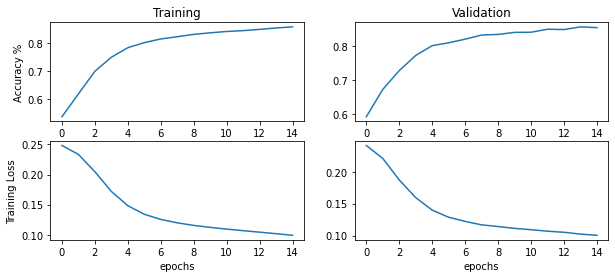

In [78]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history4.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history4.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history4.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history4.history['val_loss'])
plt.xlabel('epochs')

In [79]:
results = PrettyTable()
results.add_column("Fold", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
results.add_column("Accuracy", VALIDATION_ACCURACY4)
results.add_column("AUC", VALIDATION_AUC4)
print(results)

+------+--------------------+--------------------+
| Fold |      Accuracy      |        AUC         |
+------+--------------------+--------------------+
|  1   | 0.8550323247909546 | 0.9370723962783813 |
|  2   | 0.8647276163101196 | 0.9468874931335449 |
|  3   | 0.8536472916603088 | 0.9368804097175598 |
|  4   | 0.8379501104354858 | 0.9270048141479492 |
|  5   | 0.8836565017700195 | 0.958097517490387  |
|  6   | 0.8393352031707764 | 0.9278656244277954 |
|  7   | 0.859649121761322  | 0.9390863180160522 |
|  8   | 0.8633425831794739 | 0.9439509510993958 |
|  9   | 0.8766743540763855 | 0.9489799737930298 |
|  10  | 0.8554272651672363 | 0.9360637068748474 |
+------+--------------------+--------------------+


In [80]:
idx = VALIDATION_ACCURACY4.index(max(VALIDATION_ACCURACY4))
max_fold4 = idx + 1
print("Best Fold:", max_fold4)

Best Fold: 5


In [81]:
model4.load_weights("\saved_models4/model_"+str(max_fold4)+".h5")

# save categorical features
X_test_cat = X_test[categorical_headers].to_numpy() 

# and save off the numeric features
X_test_num = X_test[numeric_headers].to_numpy()

model4.evaluate([X_test_cat,X_test_num], y_test)

211/211 [==============================] - 0s 915us/step - loss: 0.1392 - accuracy: 0.7998 - auc: 0.8901


[0.1391681581735611, 0.7997922301292419, 0.8900622129440308]

In [93]:
yhat_proba = model4.predict([X_test_cat, X_test_num])
yhat4 = np.round(yhat_proba)

211/211 [==============================] - 0s 880us/step


### Compare W/D 1 to MLP via AUC

In [176]:
results1 = model1.evaluate([X_test_crossed,X_test_cat,X_test_num], y_test)
results4 = model4.evaluate([X_test_cat,X_test_num], y_test)

211/211 [==============================] - 0s 875us/step - loss: 0.1392 - accuracy: 0.7998 - auc: 0.8901


In [175]:
results1.__class__

list

In [181]:
comp = pd.DataFrame(columns = model4.metrics_names)
comp.loc[len(comp)] = results1
comp.loc[len(comp)] = results4
comp.head()

,loss,accuracy,auc
0,0.131323,0.810775,0.896181
1,0.139168,0.799792,0.890062


In [186]:
auc_wd = comp.loc[0]['auc']
auc_mlp = comp.loc[1]['auc']

e1 = 1 - auc_wd
e2 = 1 - auc_mlp

z_stat = 1.96 #95% CI

# e1 and e2
d12 = e1 - e2
var12 = (e1*(1 - e1) + e2*(1 - e2))/len(y_test)
print('W/D Network 1 vs. MLP (Deep Only) CI:', d12 - z_stat*np.sqrt(var12), d12 + z_stat*np.sqrt(var12))

W/D Network 1 vs. MLP (Deep Only) CI: -0.016551298489762327 0.004313511243058227


Comparing the area under the curve for the best Wide and Deep Network to the Multi-Layer Perceptron, the 95% confidence interval above includes 0, which means that the models are not significantly different from one another.

### Tabulating Models in Terms of Accuracy and AUC

In [82]:
idx1 = VALIDATION_ACCURACY1.index(max(VALIDATION_ACCURACY1))
idx11 = VALIDATION_ACCURACY11.index(max(VALIDATION_ACCURACY11))
idx12 = VALIDATION_ACCURACY12.index(max(VALIDATION_ACCURACY12))
idx2 = VALIDATION_ACCURACY2.index(max(VALIDATION_ACCURACY2))
idx21 = VALIDATION_ACCURACY21.index(max(VALIDATION_ACCURACY21))
idx22 = VALIDATION_ACCURACY22.index(max(VALIDATION_ACCURACY22))
idx3 = VALIDATION_ACCURACY3.index(max(VALIDATION_ACCURACY3))
idx31 = VALIDATION_ACCURACY31.index(max(VALIDATION_ACCURACY31))
idx32 = VALIDATION_ACCURACY32.index(max(VALIDATION_ACCURACY32))
idx4 = VALIDATION_ACCURACY4.index(max(VALIDATION_ACCURACY4))

In [84]:
results = PrettyTable()
results.field_names = ['Model', 'Accuracy', 'AUC']
results.add_row(['Wide Deep 1', VALIDATION_ACCURACY1[idx1], VALIDATION_AUC1[idx1]])
results.add_row(['Wide Deeper 1', VALIDATION_ACCURACY11[idx11], VALIDATION_AUC11[idx11]])
results.add_row(['Wide Deepest 1', VALIDATION_ACCURACY12[idx12], VALIDATION_AUC12[idx12]])
results.add_row(['Wide Deep 2', VALIDATION_ACCURACY2[idx2], VALIDATION_AUC2[idx2]])
results.add_row(['Wide Deeper 2', VALIDATION_ACCURACY21[idx21], VALIDATION_AUC21[idx21]])
results.add_row(['Wide Deepest 2', VALIDATION_ACCURACY22[idx22], VALIDATION_AUC22[idx22]])
results.add_row(['Wide Deep 3', VALIDATION_ACCURACY3[idx3], VALIDATION_AUC3[idx3]])
results.add_row(['Wide Deeper 3', VALIDATION_ACCURACY31[idx31], VALIDATION_AUC31[idx31]])
results.add_row(['Wide Deepest 3', VALIDATION_ACCURACY32[idx32], VALIDATION_AUC32[idx32]])
results.add_row(['ML Perceptron', VALIDATION_ACCURACY4[idx4], VALIDATION_AUC4[idx4]])
print(results)

+----------------+--------------------+--------------------+
|     Model      |      Accuracy      |        AUC         |
+----------------+--------------------+--------------------+
|  Wide Deep 1   | 0.8716528415679932 | 0.9496077299118042 |
| Wide Deeper 1  | 0.8651893138885498 | 0.9351232051849365 |
| Wide Deepest 1 | 0.8587257862091064 | 0.9061406254768372 |
|  Wide Deep 2   | 0.8794457316398621 | 0.9516303539276123 |
| Wide Deeper 2  | 0.8715935349464417 | 0.9421837329864502 |
| Wide Deepest 2 | 0.8684210777282715 | 0.9464473128318787 |
|  Wide Deep 3   | 0.8692840933799744 | 0.9483535885810852 |
| Wide Deeper 3  | 0.8568790555000305 | 0.9254499673843384 |
| Wide Deepest 3 | 0.8554940223693848 | 0.9467926025390625 |
| ML Perceptron  | 0.8836565017700195 | 0.958097517490387  |
+----------------+--------------------+--------------------+


In [85]:
idx1 = VALIDATION_AUC1.index(max(VALIDATION_AUC1))
idx11 = VALIDATION_AUC11.index(max(VALIDATION_AUC11))
idx12 = VALIDATION_AUC12.index(max(VALIDATION_AUC12))
idx2 = VALIDATION_AUC2.index(max(VALIDATION_AUC2))
idx21 = VALIDATION_AUC21.index(max(VALIDATION_AUC21))
idx22 = VALIDATION_AUC22.index(max(VALIDATION_AUC22))
idx3 = VALIDATION_AUC3.index(max(VALIDATION_AUC3))
idx31 = VALIDATION_AUC31.index(max(VALIDATION_AUC31))
idx32 = VALIDATION_AUC32.index(max(VALIDATION_AUC32))
idx4 = VALIDATION_AUC4.index(max(VALIDATION_AUC4))

In [86]:
results = PrettyTable()
results.field_names = ['Model', 'Accuracy', 'AUC']
results.add_row(['Wide Deep 1', VALIDATION_ACCURACY1[idx1], VALIDATION_AUC1[idx1]])
results.add_row(['Wide Deeper 1', VALIDATION_ACCURACY11[idx11], VALIDATION_AUC11[idx11]])
results.add_row(['Wide Deepest 1', VALIDATION_ACCURACY12[idx12], VALIDATION_AUC12[idx12]])
results.add_row(['Wide Deep 2', VALIDATION_ACCURACY2[idx2], VALIDATION_AUC2[idx2]])
results.add_row(['Wide Deeper 2', VALIDATION_ACCURACY21[idx21], VALIDATION_AUC21[idx21]])
results.add_row(['Wide Deepest 2', VALIDATION_ACCURACY22[idx22], VALIDATION_AUC22[idx22]])
results.add_row(['Wide Deep 3', VALIDATION_ACCURACY3[idx3], VALIDATION_AUC3[idx3]])
results.add_row(['Wide Deeper 3', VALIDATION_ACCURACY31[idx31], VALIDATION_AUC31[idx31]])
results.add_row(['Wide Deepest 3', VALIDATION_ACCURACY32[idx32], VALIDATION_AUC32[idx32]])
results.add_row(['ML Perceptron', VALIDATION_ACCURACY4[idx4], VALIDATION_AUC4[idx4]])
print(results)

+----------------+--------------------+--------------------+
|     Model      |      Accuracy      |        AUC         |
+----------------+--------------------+--------------------+
|  Wide Deep 1   | 0.8716528415679932 | 0.9496077299118042 |
| Wide Deeper 1  | 0.8651893138885498 | 0.9351232051849365 |
| Wide Deepest 1 | 0.8559556603431702 | 0.933461606502533  |
|  Wide Deep 2   | 0.8748846054077148 | 0.9543370008468628 |
| Wide Deeper 2  | 0.8715935349464417 | 0.9421837329864502 |
| Wide Deepest 2 | 0.8684210777282715 | 0.9464473128318787 |
|  Wide Deep 3   | 0.8692840933799744 | 0.9483535885810852 |
| Wide Deeper 3  | 0.8531855940818787 | 0.9371157884597778 |
| Wide Deepest 3 | 0.8554940223693848 | 0.9467926025390625 |
| ML Perceptron  | 0.8836565017700195 | 0.958097517490387  |
+----------------+--------------------+--------------------+


This was included to summarize the results of training each of the models via cross validation and choosing the best model to fit on the test set. It is interesting that the Multi-Layer Perceptron yielded the highest validation accuracy and AUC in the training process, but in the above comparison of Wide and Deep Network 1 and the Multi-Layer Perceptron, the comparison table shows that the Wide and Deep Network actually slightly (not significantly) outperformed the Multi-Layer Perceptron in terms of both measures. The dropoff from training metrics to testing metrics suggest that the MLP may be overfitting to the training data, leading to poorer relative performance on the test set. 

## Exceptional Work (1 points total)

One idea (required for 7000 level students): Capture the embedding weights from the deep network and (if needed) perform dimensionality reduction on the output of these embedding layers (only if needed). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data.

Although there was no significant difference between WD 1 and the MLP, we elected to move forward with WD 1 as our best model since it yielded slightly better metrics on the test set. 

In [188]:
model1.load_weights("\saved_models1/model_"+str(max_fold1)+".h5")

y_test = y_test.reshape(-1,1)
    
# get crossed columns
X_test_crossed = X_test[cross_col_df_names1].to_numpy()

# save categorical features
X_test_cat = X_test[categorical_headers].to_numpy() 

# and save off the numeric features
X_test_num = X_test[numeric_headers].to_numpy()

model1.evaluate([X_test_crossed,X_test_cat,X_test_num], y_test)

211/211 [==============================] - 0s 1ms/step - loss: 0.1313 - accuracy: 0.8108 - auc: 0.8962


[0.13132330775260925, 0.8107746839523315, 0.8961811065673828]

In [189]:
from sklearn.manifold import TSNE

M_range_int_embed = []
M_range_weight = model1.get_layer("opp_int_embed").get_weights()[0]
np.set_printoptions(suppress=True) # stop using scientific notation
M_range = encoders["opp"].classes_


# extract the x and y
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=0, verbose=1)
df_tsne = pd.DataFrame(data=tsne.fit_transform(M_range_weight))

x_opp_list = df_tsne[0]
y_opp_list = df_tsne[1]
M_range_weight

/Users/kirstinpruitt/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 32 nearest neighbors...
[t-SNE] Indexed 33 samples in 0.000s...
[t-SNE] Computed neighbors for 33 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 33 / 33
[t-SNE] Mean sigma: 0.096154
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.813271
[t-SNE] KL divergence after 1000 iterations: 0.476044


/Users/kirstinpruitt/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


array([[-0.02014561,  0.03297092, -0.02997809,  0.01213219, -0.03398019],
       [-0.03040902, -0.02834615, -0.01151936, -0.02793972,  0.03797956],
       [ 0.03350912,  0.04813427, -0.00423335, -0.04868061, -0.0022204 ],
       [ 0.02963015,  0.04146936,  0.01080802,  0.04057513, -0.03049114],
       [ 0.02898294, -0.03535194,  0.03255196,  0.02503607, -0.00862897],
       [ 0.04315138,  0.01258979, -0.01565821, -0.00746944,  0.04414979],
       [-0.01266565,  0.0055846 , -0.01247183, -0.00753132, -0.02020855],
       [-0.00817852,  0.02491612,  0.03744063,  0.01120474,  0.03291049],
       [-0.00599928,  0.01932077,  0.04533894,  0.0274847 ,  0.01999759],
       [ 0.01204183,  0.03171245,  0.04183075,  0.02129509,  0.02776867],
       [-0.01717252, -0.03425907,  0.03376386,  0.02116618, -0.04160946],
       [-0.01471838, -0.00748398,  0.03727069,  0.03725231,  0.04085338],
       [-0.00077312, -0.01182045,  0.02148054, -0.01146497,  0.02910047],
       [ 0.00554908, -0.01933683,  0.0

`opp` (opponent) categorical feature has 5 weights, so we used dimensionality reduction to reduce it to two dimensions that can be plotted.

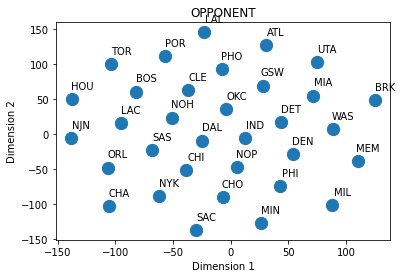

In [191]:
index = 0
for x,y in zip(x_opp_list, y_opp_list):
    ar = M_range[index]
    plt.annotate(ar,xy=(x,y), textcoords='offset points',xytext=(10,10),ha='center')
    index += 1
    
plt.scatter(x_opp_list, y_opp_list, s=150)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('OPPONENT')
plt.show()

From this we can see that Dimension 1 has strong, positive weight on the opponents:
* Brooklyn Nets
* Memphis Grizzlies
* Milwaukee Bucks
* Washington Wizards
* Utah Jazz*
* Miami Heat

And Dimension 2 has strong, positive weight on the opponents:
* Los Angeles Lakers
* Atlanta Hawks
* Portland Trail Blazers
* Toronto Raptors
* Utah Jazz* 

*The Utah Jazz have relatively strong, positive pull in both dimensions as an `opp`onent in the model. 

The three opponents toward the top right corner (Utah Jazz, Brooklyn Nets, and Miami Heat) made the playoffs in all 3 seasons captured by the test set, which is interesting. But also toward the bottom right corner is the Denver Nuggets, Philadelpha 76ers, and Milwaukee Bucks, all of which also made playoffs in all 3 seasons captured by the set. This leads us to believe that positive values in dimension 1 are associated with opponents that consistently make the playoffs. 
The opponents toward the top of the plot (higher in D2) are the Toronto Raptors, Portland Trail Blazers, Los Angeles Lakers, Atlanta Hawks, and Phoenix Suns, which have all made the playoffs in 2 out of the 3 seasons captured by the test set. It seems dimension 2 is drawn toward opponents with slightly less consistent playoff appearances. 

When these teams are considered as `opp`onents of playoff contending teams in the data (`team`), they tend to all show up around 3 times per season with respect to making the playoffs, which stands to reason why, while patterns can be found if you really look for them, no overly straightforward clusters exist in the plot. 

In [192]:
M_range_int_embed = []
M_range_weight = model1.get_layer("team_int_embed").get_weights()[0]
np.set_printoptions(suppress=True) # stop using scientific notation
M_range = encoders["team"].classes_

# extract the x and y
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=0, verbose=1)
df_tsne = pd.DataFrame(data=tsne.fit_transform(M_range_weight))

x_team_list = df_tsne[0]
y_team_list = df_tsne[1]
M_range_weight

/Users/kirstinpruitt/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/kirstinpruitt/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 32 nearest neighbors...
[t-SNE] Indexed 33 samples in 0.000s...
[t-SNE] Computed neighbors for 33 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 33 / 33
[t-SNE] Mean sigma: 0.290177
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.886536
[t-SNE] KL divergence after 1000 iterations: 0.485992


array([[-0.13619524, -0.05463667, -0.02835846,  0.01547332,  0.05135334],
       [-0.18305793, -0.15432209, -0.04512396,  0.03827106,  0.08188966],
       [-0.08833788, -0.13188176, -0.05110819,  0.01518409,  0.10438135],
       [-0.05376689,  0.00540017, -0.03633734,  0.0216775 ,  0.02990292],
       [-0.05312058, -0.07436866,  0.03635632,  0.05757541,  0.00846354],
       [ 0.10563949,  0.10392869,  0.01462496, -0.01559461, -0.05752672],
       [ 0.0542198 , -0.02770237,  0.01040779, -0.00716587, -0.01685554],
       [ 0.01862507,  0.01421726, -0.00885912, -0.04453662, -0.00664289],
       [ 0.10798551,  0.03915451,  0.04790034, -0.05873429, -0.00489335],
       [ 0.06885544,  0.0426164 ,  0.00972028, -0.03002984, -0.05703871],
       [-0.04412824, -0.05309712,  0.02167544,  0.01307528, -0.04848194],
       [-0.02325713,  0.01334699, -0.02089662, -0.02593241,  0.02687943],
       [-0.21367806, -0.16620047, -0.00950234,  0.07042745,  0.03202091],
       [-0.02667118, -0.05960885,  0.0

`team` also has 5 categorical feature weights, so we again used dimensionality reduction to reduce it to two dimensions that can be plotted.

In [ ]:
#df_tsne

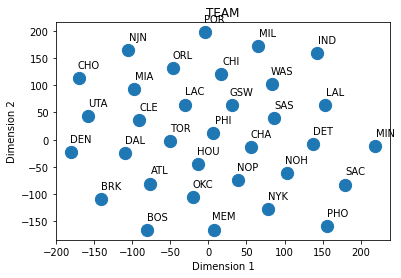

In [195]:
index = 0
for x,y in zip(x_team_list, y_team_list):
    ar = M_range[index]
    plt.annotate(ar,xy=(x,y), textcoords='offset points',xytext=(10,10),ha='center')
    index += 1
    

plt.scatter(x_team_list, y_team_list, s=150)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('TEAM')
plt.show()

From this we can see that Dimension 1 has strong, positive weight on the teams:
* Minnesota Timberwolves
* Sacramento Kings 
* Phoenix Suns
* Los Angeles Lakers
* Indiana Pacers*

And Dimension 2 has strong, positive weight on the opponents:
* Portland Trail Blazers
* New Jersey Nets (became Brooklyn Nets in 2013 Season)
* Milwaukee Bucks
* Indiana Pacers* 
* Orlando Magic

*The Indiana Pacers have relatively strong, positive pull in both dimensions as a `team` in the model. 

Toward the left side of the plot, we see some fairly consistent playoff contenders from the test set: 
* Brooklyn Nets (3/3 seasons)
* Boston Celtics (3/3 seasons)
* Dallas Mavericks (3/3 seasons)
* Utah Jazz (3/3 seasons)
* Miami Head (3/3 seasons)
* Atlanta Hawks (2/3 seasons)
* Toronto Raptors (2/3 seasons)
* Los Angeles Clippers (2/3 seasons) 

It is interesting that these teams pull strong, negative weight in dimension 1. 

The Milwaukee Bucks (3/3) and Portland Trail Blazers (2/3) pull strong, positive weight for dimension 2.

Again it seems that while patterns can be hunted down in the plot, there is not convincing evidence that straightforward, interpretable clusters exist for the `team` variable either, which may mean that `team` and `opp` don't heavily influence the whether or not a game will result in a positive or negative playoff prediction. 

#### Sources

[k-fold model example 1](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md)

[k-fold model example 2 (used)](https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538)